In [1]:
%reload_ext autoreload
%autoreload 2

# 1) Run the modelling

First set the directory holding the data.

In [2]:
from mutants_in_pcm import data_path
data_path.data_dir = '../data'

Now run the modelling part (or ensure it was run properly).

In [3]:
from mutants_in_pcm import modelling

In [4]:
modelling.model_bioactivity_data()
modelling.model_bioactivity_data_common_subsets()

  0%|                                                                                           | 0/335 [00:00…

  0%|                                                                                           | 0/335 [00:00…

# 2) Run the analysis

## Imports

Now import all other libraries for the analysis of the modelling results.

In [2]:
import os
import re
import gzip
import lzma
import zipfile
import json
import pathlib
from itertools import chain

import base64
import inspect
import importlib

from natsort import natsorted

import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from scipy.stats import ttest_ind

from IPython.display import SVG, Image

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib import colormaps
from PyComplexHeatmap import *
from adjustText import adjust_text

## Read results

Define where modelling results are stored and outputs and plots will be stored.

In [3]:
modelling_data_dir = '../data/modelling'
output_data_dir = '../analysis/modelling'
output_plot_dir = '../analysis/modelling_plots'

for dirpath in [output_data_dir, output_plot_dir]:
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

Read results of the modelling of bioactivities with machine learning.

Aggregate all results for PCM and QSAR for both types of cross validations:
- random 5-fold CV
- mutant-grouped KFold CV

and for:
- the complete dataset
- the dataset with mutants removed

In [4]:
data = []
# PCM random CV
for fpath in natsorted(pathlib.Path(modelling_data_dir).glob('*.tsv')):
    accession = fpath.as_posix().split('_')[-1].split('.')[0]
    subset = pd.read_csv(fpath.as_posix(), sep='\t', index_col=0).reset_index()
    subset['accession'] = accession
    subset['subset'] = 'common' if 'common_subset' in str(fpath) else 'complete'
    subset['contains_mutants'] = False if 'nomutant' in str(fpath) else True
    subset['modeltype'] = 'PCM' if 'pcm' in str(fpath) else 'QSAR'
    subset['crossval'] = 'random' if 'randomsplit' in str(fpath) else 'per mutant'
    subset['path'] = str(fpath)
    data.append(subset)
data = pd.concat(data)
data = data.rename(columns={'index': 'folds'})
data.to_csv(os.path.join(output_data_dir, 'all_modelling_results.tsv.xz'), sep='\t', index=False)

Determine the order of accessions based on the amount of data points.

In [5]:
order = data[(data.subset == 'complete') & (data.modeltype == 'PCM') & (data.crossval == 'random') & (data.folds == 'Mean') & (data.contains_mutants == True)].sort_values('number', ascending=False).accession[:40]
data1 = data[data.accession.isin(order)]
data1['accession'] = data1.accession.astype("category")
data1['accession'] = data1.accession.cat.set_categories(order)

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\904326800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['accession'] = data1.accession.astype("category")
C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\904326800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['accession'] = data1.accession.cat.set_categories(order)


## Plot scatter plots of CV fold performance

Carry out t-tests between PCM and QSAR results on the random CV.

In [6]:
metrics = 'Pearson r'
pval_thresh = 0.05

In [7]:
replacements = {}
for accession in order:
    # Isolate values of each fold
    x1 = data1[(data1.subset == 'complete') & (data1.accession == accession) & (data1.modeltype == 'PCM') & (data1.crossval == 'random') & (data1.contains_mutants == True) & (~data1.folds.isin(['Mean', 'SD']))][metrics]
    x2 = data1[(data1.subset == 'complete') & (data1.accession == accession) & (data1.modeltype == 'QSAR') & (data1.crossval == 'random') & (data1.contains_mutants == True) & (~data1.folds.isin(['Mean', 'SD']))][metrics]
    # Carry out t-test
    t_test = ttest_ind(x1, x2, equal_var=False)
    if t_test.pvalue < pval_thresh:
        replacements[accession] = '* ' + accession
old_accessions = {value: key for key, value in replacements.items()}
data1.loc[:, 'accession'] = data1.accession.cat.rename_categories(replacements)

Plot the performance differences.

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\2761442109.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\2761442109.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])


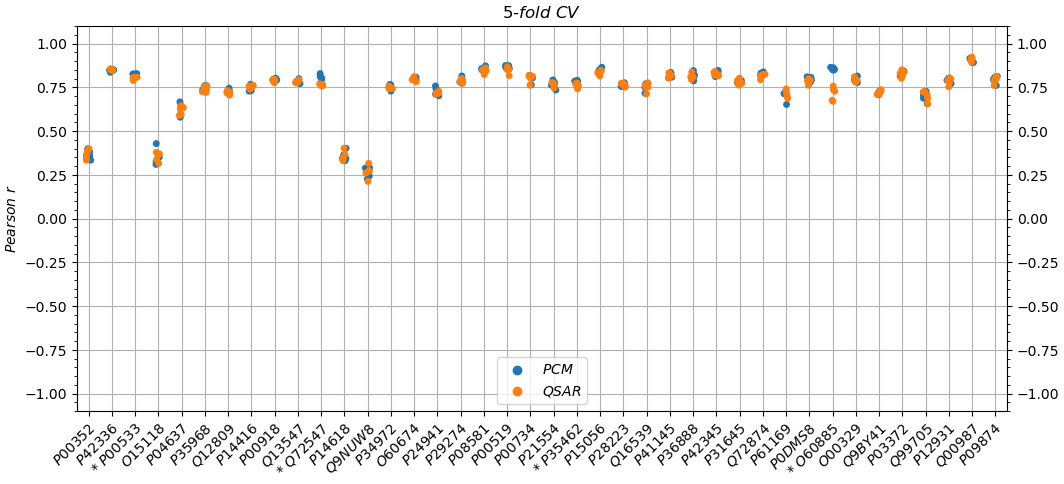

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot data
sns.stripplot(data=data1[(data1.crossval == 'random') & (data1.subset == 'complete') & (~data1.folds.isin(['Mean', 'SD'])) & (data1.contains_mutants)].reset_index(),
              x='accession', hue='modeltype', y=metrics, ax=ax)
# Set title, axes labels and y limits
_ = ax.set(title='$5$-$fold$ $CV$', xlabel='', ylabel=' '.join(f'${word}$' for word in metrics.split()), ylim=(-1.1, 1.1))
# Rotate and right align x labels
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
# Adapt legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], loc='lower center')
l = ax.get_legend()
mappings = {'PCM': '$PCM$', 'QSAR': '$QSAR$'}
for text in l.get_texts():
    _ = text.set_text(mappings[text.get_text()])
# Add minor ticks on y axis
ax.tick_params(axis='y', which='both', reset=True, direction='out', labelright=True)
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# Set grid on
ax.grid(True)
# Latex-ify x labels
_ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])

Now with the LOMO (leave one mutant out) CV on the complete data.

In [9]:
# Reset accession names
data1['accession'] = data1.accession.cat.rename_categories(old_accessions)

replacements = {}
for accession in order:
    # Isolate values of each fold
    x1 = data1[(data1.subset == 'complete') & (data1.accession == accession) & (data1.modeltype == 'PCM') & (data1.crossval == 'per mutant') & (~data1.folds.isin(['Mean', 'SD'])) & (data1.contains_mutants == True)][metrics]
    x2 = data1[(data1.subset == 'complete') & (data1.accession == accession) & (data1.modeltype == 'QSAR') & (data1.crossval == 'per mutant') & (~data1.folds.isin(['Mean', 'SD'])) & (data1.contains_mutants == True)][metrics]
    # Carry out t-test
    t_test = ttest_ind(x1, x2, equal_var=False)
    if t_test.pvalue < pval_thresh:
        replacements[accession] = '* ' + accession
old_accessions = {value: key for key, value in replacements.items()}
data1['accession'] = data1.accession.cat.rename_categories(replacements)

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\3251228816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['accession'] = data1.accession.cat.rename_categories(old_accessions)
C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\3251228816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['accession'] = data1.accession.cat.rename_categories(replacements)


C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\2839153188.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\2839153188.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])


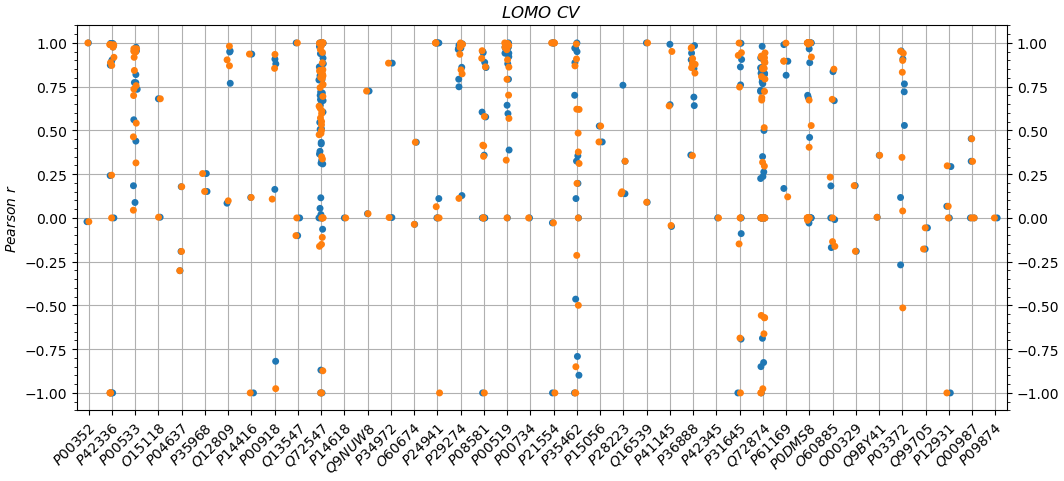

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot data
sns.stripplot(data=data1[(data1.subset == 'complete') & (data1.crossval == 'per mutant') & (~data1.folds.isin(['Mean', 'SD'])) & (data1.contains_mutants == True)].reset_index(),
              x='accession', hue='modeltype', y=metrics, ax=ax, legend=False)
# Set title, axes labels and y limits
_ = ax.set(title='$LOMO$ $CV$', xlabel='', ylabel=' '.join(f'${word}$' for word in metrics.split()), ylim=(-1.1, 1.1))
# Rotate and right align x labels
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
# Adapt legend
handles, labels = ax.get_legend_handles_labels()
# Add minor ticks on y axis
ax.tick_params(axis='y', which='both', reset=True, direction='out', labelright=True)
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# Set grid on
ax.grid(True)
# Latex-ify x labels
_ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])

Repeat with the CV on the common subset.

In [11]:
# Reset accession names
data1['accession'] = data1.accession.cat.rename_categories(old_accessions)

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\63880958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['accession'] = data1.accession.cat.rename_categories(old_accessions)


In [12]:
order_common = data[(data.subset == 'common') & (data.modeltype == 'PCM') & (data.crossval == 'random') & (data.folds == 'Mean') & data.contains_mutants].sort_values('number', ascending=False).accession[:40]
data2 = data[data.accession.isin(order)]
data2['accession'] = data2.accession.astype("category")
data2['accession'] = data2.accession.cat.set_categories(order_common)

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\1895583179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['accession'] = data2.accession.astype("category")
C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\1895583179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['accession'] = data2.accession.cat.set_categories(order_common)


In [13]:
replacements = {}
for accession in order:
    # Isolate values of each fold
    x1 = data2[(data2.subset == 'common') & (data2.accession == accession) & (data2.modeltype == 'PCM') & (data2.crossval == 'random') & (~data2.folds.isin(['Mean', 'SD'])) & data2.contains_mutants][metrics]
    x2 = data2[(data2.subset == 'common') & (data2.accession == accession) & (data2.modeltype == 'QSAR') & (data2.crossval == 'random') & (~data2.folds.isin(['Mean', 'SD'])) & data2.contains_mutants][metrics]
    # Carry out t-test
    t_test = ttest_ind(x1, x2, equal_var=False)
    if t_test.pvalue < pval_thresh:
        replacements[accession] = '* ' + accession
old_accessions = {value: key for key, value in replacements.items()}
data2['accession'] = data2.accession.cat.rename_categories(replacements)

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\1920435612.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['accession'] = data2.accession.cat.rename_categories(replacements)


In [14]:
data2[(data2.crossval == 'random') & (data2.subset == 'common') & (~data2.folds.isin(['Mean', 'SD'])) & (data2.contains_mutants)].reset_index().accession.tolist()

[nan,
 nan,
 nan,
 nan,
 nan,
 '* O60674',
 '* O60674',
 '* O60674',
 '* O60674',
 '* O60674',
 '* O60885',
 '* O60885',
 '* O60885',
 '* O60885',
 '* O60885',
 nan,
 nan,
 nan,
 nan,
 nan,
 '* P00519',
 '* P00519',
 '* P00519',
 '* P00519',
 '* P00519',
 '* P00533',
 '* P00533',
 '* P00533',
 '* P00533',
 '* P00533',
 nan,
 nan,
 nan,
 nan,
 nan,
 '* P03372',
 '* P03372',
 '* P03372',
 '* P03372',
 '* P03372',
 '* P08581',
 '* P08581',
 '* P08581',
 '* P08581',
 '* P08581',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '* P15056',
 '* P15056',
 '* P15056',
 '* P15056',
 '* P15056',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '* P29274',
 '* P29274',
 '* P29274',
 '* P29274',
 '* P29274',
 '* P31645',
 '* P31645',
 '* P31645',
 '* P31645',
 '* P31645',
 nan,
 nan,
 nan,
 nan,
 nan,
 'P35462',
 'P35462',
 'P35462',
 'P35462',
 'P35462',
 '* P36888',
 '* P36888',
 '* P36888',
 '* P36888',
 '* P36888',
 nan,
 nan,
 nan,
 nan,
 

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\3029681748.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\3029681748.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])


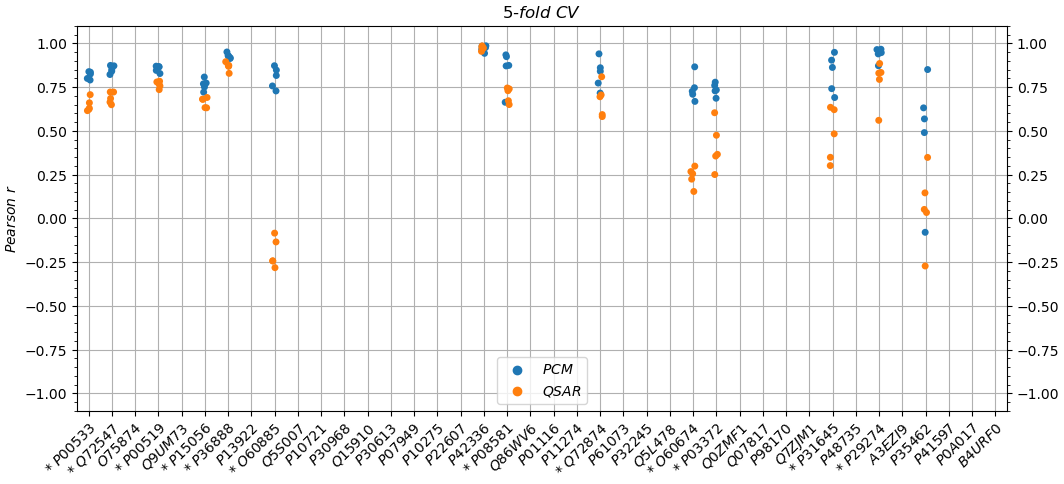

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot data
sns.stripplot(data=data2[(data2.crossval == 'random') & (data2.subset == 'common') & (~data2.folds.isin(['Mean', 'SD'])) & (data2.contains_mutants)].reset_index(),
              x='accession', hue='modeltype', y=metrics, ax=ax)
# Set title, axes labels and y limits
_ = ax.set(title='$5$-$fold$ $CV$', xlabel='', ylabel=' '.join(f'${word}$' for word in metrics.split()), ylim=(-1.1, 1.1))
# Rotate and right align x labels
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
# Adapt legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], loc='lower center')
l = ax.get_legend()
mappings = {'PCM': '$PCM$', 'QSAR': '$QSAR$'}
for text in l.get_texts():
    _ = text.set_text(mappings[text.get_text()])
# Add minor ticks on y axis
ax.tick_params(axis='y', which='both', reset=True, direction='out', labelright=True)
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# Set grid on
ax.grid(True)
# Latex-ify x labels
_ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])

Repeat for LOMO CV on the common subset.

In [16]:
# Reset accession names
data1['accession'] = data1.accession.cat.rename_categories(old_accessions)

replacements = {}
for accession in order:
    # Isolate values of each fold
    x1 = data1[(data1.subset == 'common') & (data1.accession == accession) & (data1.modeltype == 'PCM') & (data1.crossval == 'per mutant') & (~data1.folds.isin(['Mean', 'SD'])) & (data1.contains_mutants == True)][metrics]
    x2 = data1[(data1.subset == 'common') & (data1.accession == accession) & (data1.modeltype == 'QSAR') & (data1.crossval == 'per mutant') & (~data1.folds.isin(['Mean', 'SD'])) & (data1.contains_mutants == True)][metrics]
    # Carry out t-test
    t_test = ttest_ind(x1, x2, equal_var=False)
    if t_test.pvalue < pval_thresh:
        replacements[accession] = '* ' + accession
old_accessions = {value: key for key, value in replacements.items()}
data1['accession'] = data1.accession.cat.rename_categories(replacements)

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\2241197641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['accession'] = data1.accession.cat.rename_categories(old_accessions)
C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\2241197641.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['accession'] = data1.accession.cat.rename_categories(replacements)


C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\1048982938.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\1048982938.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])


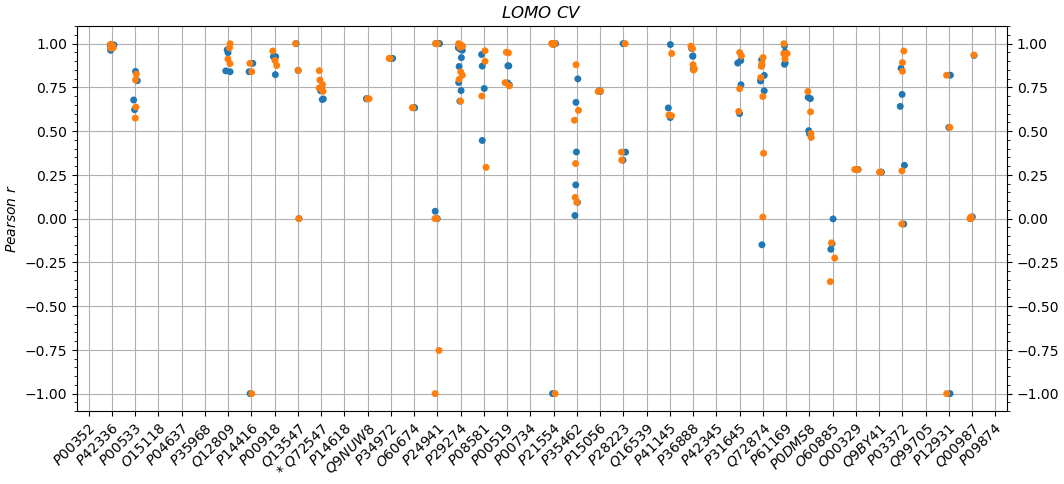

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot data
sns.stripplot(data=data1[(data1.subset == 'common') & (data1.crossval == 'per mutant') & (~data1.folds.isin(['Mean', 'SD'])) & data1.contains_mutants].reset_index(),
              x='accession', hue='modeltype', y=metrics, ax=ax, legend=False)
# Set title, axes labels and y limits
_ = ax.set(title='$LOMO$ $CV$', xlabel='', ylabel=' '.join(f'${word}$' for word in metrics.split()), ylim=(-1.1, 1.1))
# Rotate and right align x labels
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
# Adapt legend
handles, labels = ax.get_legend_handles_labels()
# Add minor ticks on y axis
ax.tick_params(axis='y', which='both', reset=True, direction='out', labelright=True)
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# Set grid on
ax.grid(True)
# Latex-ify x labels
_ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])

Summarize p-values.

In [18]:
# Reset accession names
data1['accession'] = data1.accession.cat.rename_categories(old_accessions)

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\63880958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['accession'] = data1.accession.cat.rename_categories(old_accessions)


In [19]:
results = {}
for accession in tqdm(data.accession.unique()):
    # T-test for random CV
    x1 = data[(data.subset == 'complete') & (data.accession == accession) & (data.modeltype == 'PCM') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD'])) & (data.contains_mutants == True)][metrics]
    x2 = data[(data.subset == 'complete') & (data.accession == accession) & (data.modeltype == 'QSAR') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD'])) & (data.contains_mutants == True)][metrics]
    random_t_test = ttest_ind(x1, x2, equal_var=False).pvalue
    # T-test for per mutant CV
    x1 = data[(data.subset == 'complete') & (data.accession == accession) & (data.modeltype == 'PCM') & (data.crossval == 'per mutant') & (~data.folds.isin(['Mean', 'SD'])) & (data.contains_mutants == True)][metrics]
    x2 = data[(data.subset == 'complete') & (data.accession == accession) & (data.modeltype == 'QSAR') & (data.crossval == 'per mutant') & (~data.folds.isin(['Mean', 'SD'])) & (data.contains_mutants == True)][metrics]
    mutant_t_test = ttest_ind(x1, x2, equal_var=False).pvalue
    results[accession] = {'random': random_t_test, 'mutant': mutant_t_test}
results = pd.DataFrame.from_dict(results, orient='index')

  0%|          | 0/329 [00:00<?, ?it/s]

In [20]:
results.dropna().sort_values('random')

,random,mutant
Q72547,0.000642,0.802489
O60885,0.000912,0.974867
A0A045ISB3,0.004795,0.662232
P00533,0.006682,0.982020
P13922,0.009656,0.839692
...,...,...
P21589,1.000000,1.000000
O43613,1.000000,1.000000
P03952,1.000000,1.000000
Q96HE7,1.000000,1.000000


In [21]:
(results.random < 0.05).sum(), (results.mutant < 0.05).sum()

(15, 0)

## Simple heatmaps

Obtain counts of datapoints used for modeling

In [22]:
num_data_points = (data[(data.subset == 'complete') & (data.modeltype == 'PCM') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD'])) & data.contains_mutants]
                        .groupby('accession')
                        .agg({'number': 'sum'})
                        .sort_values('number', ascending=False)
                        .reset_index()
                        .rename(columns={'number': 'num_datapoints_total'})
)
num_mutant_data_points = (data[(data.subset == 'complete') & (data.modeltype == 'PCM') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD'])) & ~data.contains_mutants]
                        .groupby('accession')
                        .agg({'number': 'sum'})
                        .sort_values('number', ascending=False)
                        .reset_index()
                        .rename(columns={'number': 'num_datapoints_WT'})
)
counts = num_data_points.merge(num_mutant_data_points, on='accession', how='outer').fillna(0)
counts['num_datapoints_mutants'] = counts.num_datapoints_total - counts.num_datapoints_WT
counts.to_csv(os.path.join(output_data_dir, 'all_modelling_counts.tsv.xz'), sep='\t', index=False)

### Order accessions by the amount of data points

In [23]:
heatmap_data = pd.concat([pd.concat([pd.Series(['complete'] * 4, name='dataset'),
                                     (data[(data.subset == 'complete') & (data.folds == 'Mean') & data.contains_mutants]
                                      .drop(columns=[col for col in data.columns
                                                     if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                      .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                      .reset_index())],
                                    axis=1),
                          pd.concat([pd.Series(['common'] * 4, name='dataset'),
                                     (data[(data.subset == 'common') & (data.folds == 'Mean') & data.contains_mutants]
                                          .drop(columns=[col for col in data.columns
                                                         if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                          .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                          .reset_index())],
                                    axis=1),
                          pd.concat([pd.Series(['no mutant'] * 2, name='dataset'),
                                     (data[(data.subset == 'complete') & (data.folds == 'Mean') & ~data.contains_mutants]
                                          .drop(columns=[col for col in data.columns
                                                         if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                          .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                          .reset_index())],
                                    axis=1)
                          ],
                         axis=0)
# heatmap_data = heatmap_data.dropna(axis=1)
order = counts[counts.accession.isin(heatmap_data.columns)].sort_values('num_datapoints_total', ascending=False).accession[:20].tolist()
heatmap_data = heatmap_data[['dataset', 'crossval', 'modeltype'] + order]
heatmap_data = (heatmap_data.sort_values('modeltype', key=lambda x: x.map({'PCM': 0, 'QSAR': 1}))
                            .sort_values('dataset', key=lambda x: x.map({'complete': 0, 'no mutant': 1, 'common': 2}))
                            .sort_values('crossval', key=lambda x: x.map({'random': 0, 'per mutant': 1})))

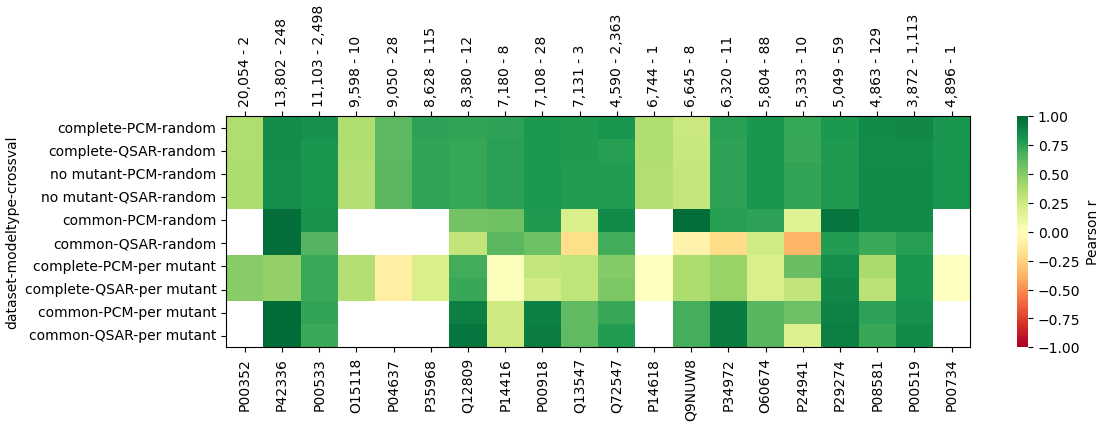

In [24]:
fig, ax = plt.subplots(figsize=(12, 3))

# Plot data
_ = ax.grid(False)
sns.heatmap(data=heatmap_data.set_index(['dataset', 'modeltype', 'crossval']),
            vmin=-1,
            vmax=1,
            cmap='RdYlGn',
            ax=ax,
            cbar_kws={'label': metrics})

# Obtain x ticklabels in heatmap
xtickslocs = ax.get_xticks()
ymin, _ = ax.get_ylim()
ticks_pos = ax.transData.transform([(xtick, ymin) for xtick in xtickslocs])[:,0]
tick_labels = [xtick.get_text() for xtick in ax.get_xticklabels()]
tick_mapping_most_data = pd.concat([pd.Series(ticks_pos, name='x'), pd.Series(tick_labels, name='text')], axis=1)
tick_mapping_most_data = tick_mapping_most_data.merge(counts, left_on='text', right_on='accession')
tick_mapping_most_data.loc[:, 'number'] = [f'{int(tick_mapping_most_data.num_datapoints_WT[i]):,} - {int(tick_mapping_most_data.num_datapoints_mutants[i]):,}' for i, _ in tick_mapping_most_data.iterrows()]

ax2 = ax.twiny()
_ = ax2.grid(False)
ax2.set_xlim(ax.get_xlim())
_ = ax2.set_xticks(xtickslocs)
_ = ax2.set_xticklabels(tick_mapping_most_data.number, rotation=90, va='center', ha='left', rotation_mode='anchor')

### Order accession by highest mutant to WT ratio


In [25]:
ratios = counts[:]
ratios['datapoints_mutant_percentage'] = counts.num_datapoints_mutants / counts.num_datapoints_total * 100
ratios = ratios.sort_values('datapoints_mutant_percentage', ascending=False)
ratios = ratios[ratios.num_datapoints_WT > 0]
ratios = ratios[ratios.num_datapoints_total > 30]

C:\Users\ojbeq\AppData\Local\Temp\ipykernel_47168\1401192892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios['datapoints_mutant_percentage'] = counts.num_datapoints_mutants / counts.num_datapoints_total * 100


In [26]:
ratio_heatmap = data.merge(ratios, on='accession').sort_values('datapoints_mutant_percentage', ascending=False)
ratio_heatmap['balance_coeff'] = (2 * (0.5 - ((50 - ratio_heatmap.datapoints_mutant_percentage) / 100).abs()))

In [27]:
ratio_order = (ratio_heatmap[(ratio_heatmap.subset == 'complete') & (ratio_heatmap.modeltype == 'PCM') &
                            (ratio_heatmap.crossval == 'random') & (ratio_heatmap.folds == 'Mean') & ratio_heatmap.contains_mutants]
               .sort_values(['balance_coeff', 'num_datapoints_total'], ascending=False)
               .accession
               .tolist()
               )

In [28]:
ratio_heatmap['accession'] = ratio_heatmap.accession.astype("category")
ratio_heatmap['accession'] = ratio_heatmap.accession.cat.set_categories(ratio_order)

In [29]:
ratio_heatmap = pd.concat([pd.concat([pd.Series(['complete'] * 4, name='dataset'),
                                     (ratio_heatmap[(ratio_heatmap.subset == 'complete') & (ratio_heatmap.folds == 'Mean') & ratio_heatmap.contains_mutants]
                                      .drop(columns=[col for col in ratio_heatmap.columns
                                                     if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                      .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                      .reset_index())],
                                    axis=1),
                           pd.concat([pd.Series(['common'] * 4, name='dataset'),
                                      (ratio_heatmap[(ratio_heatmap.subset == 'common') & (ratio_heatmap.folds == 'Mean') & ratio_heatmap.contains_mutants]
                                           .drop(columns=[col for col in ratio_heatmap.columns
                                                          if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                           .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                           .reset_index())],
                                     axis=1),
                           pd.concat([pd.Series(['no mutant'] * 2, name='dataset'),
                                      (ratio_heatmap[~ratio_heatmap.contains_mutants & (ratio_heatmap.folds == 'Mean') & ~ratio_heatmap.contains_mutants]
                                           .drop(columns=[col for col in ratio_heatmap.columns
                                                          if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                           .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                           .reset_index())],
                                     axis=1)
                           ],
                         axis=0)
# ratio_heatmap = ratio_heatmap.dropna(axis=1)
ratio_heatmap = ratio_heatmap.iloc[:, :23]
ratio_heatmap = (ratio_heatmap.sort_values('modeltype', key=lambda x: x.map({'PCM': 0, 'QSAR': 1}))
                              .sort_values('dataset', key=lambda x: x.map({'complete': 0, 'common': 1}))
                              .sort_values('crossval', key=lambda x: x.map({'random': 0, 'per mutant': 1})))

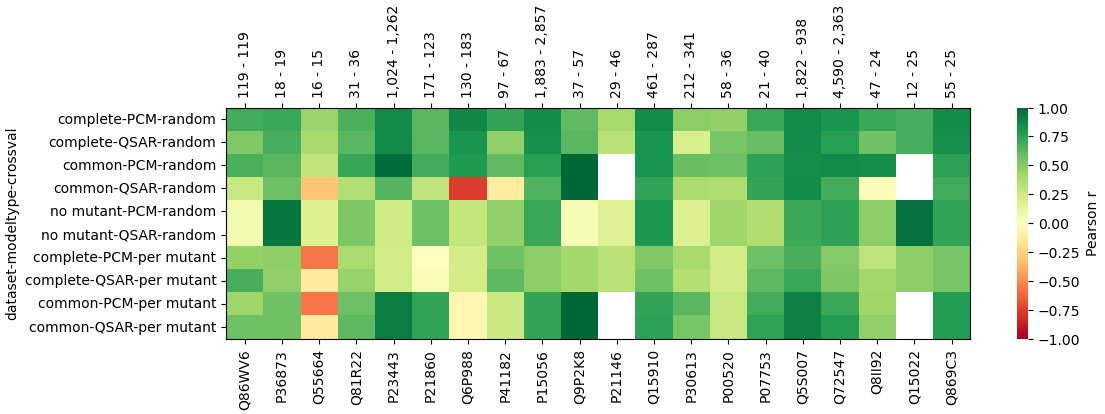

In [30]:
fig, ax = plt.subplots(figsize=(12, 3))

# Plot data
_ = ax.grid(False)
sns.heatmap(data=ratio_heatmap.set_index(['dataset', 'modeltype', 'crossval']),
            vmin=-1,
            vmax=1,
            cmap='RdYlGn',
            ax=ax,
            cbar_kws={'label': metrics})

# Obtain x ticklabels in heatmap
xtickslocs = ax.get_xticks()
ymin, _ = ax.get_ylim()
ticks_pos = ax.transData.transform([(xtick, ymin) for xtick in xtickslocs])[:,0]
tick_labels = [xtick.get_text() for xtick in ax.get_xticklabels()]
tick_mapping_ratio = pd.concat([pd.Series(ticks_pos, name='x'), pd.Series(tick_labels, name='text')], axis=1)
tick_mapping_ratio = pd.concat([pd.Series(ticks_pos, name='x'), pd.Series(tick_labels, name='text')], axis=1)
tick_mapping_ratio = tick_mapping_ratio.merge(counts, left_on='text', right_on='accession')
tick_mapping_ratio.loc[:, 'number'] = [f'{int(tick_mapping_ratio.num_datapoints_WT[i]):,} - {int(tick_mapping_ratio.num_datapoints_mutants[i]):,}' for i, _ in tick_mapping_ratio.iterrows()]

ax2 = ax.twiny()
_ = ax2.grid(False)
ax2.set_xlim(ax.get_xlim())
_ = ax2.set_xticks(xtickslocs)
_ = ax2.set_xticklabels(tick_mapping_ratio.number, rotation=90, va='center', ha='left', rotation_mode='anchor')

### Ordered by accessions with most data points related to mutant 

In [31]:
most_mutant = data.merge(counts, on='accession')
most_mutant_order = (most_mutant[(most_mutant.subset == 'complete') & (most_mutant.modeltype == 'PCM') &
                                 (most_mutant.crossval == 'random') & (most_mutant.folds == 'Mean') & most_mutant.contains_mutants]
                     .sort_values('num_datapoints_mutants', ascending=False)
                     .accession
                     .tolist()
                     )
most_mutant['accession'] = most_mutant.accession.astype("category")
most_mutant['accession'] = most_mutant.accession.cat.set_categories(most_mutant_order)

In [32]:
most_mutant_heatmap = pd.concat([pd.concat([pd.Series(['complete'] * 4, name='dataset'),
                                            (most_mutant[(most_mutant.subset == 'complete') & (most_mutant.folds == 'Mean') & most_mutant.contains_mutants]
                                            .drop(columns=[col for col in most_mutant.columns
                                                            if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                            .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                            .reset_index())],
                                            axis=1),
                                 pd.concat([pd.Series(['common'] * 4, name='dataset'),
                                             (most_mutant[(most_mutant.subset == 'common') & (most_mutant.folds == 'Mean') & most_mutant.contains_mutants]
                                                 .drop(columns=[col for col in most_mutant.columns
                                                                 if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                                 .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                                 .reset_index())],
                                             axis=1),
                                 pd.concat([pd.Series(['no mutant'] * 2, name='dataset'),
                                             (most_mutant[(most_mutant.subset == 'complete') & (most_mutant.folds == 'Mean') & ~most_mutant.contains_mutants]
                                                 .drop(columns=[col for col in most_mutant.columns
                                                                 if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                                 .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                                 .reset_index())],
                                             axis=1)
                                 ],
                                axis=0)
# most_mutant_heatmap = most_mutant_heatmap.dropna(axis=1)
most_mutant_heatmap = most_mutant_heatmap.iloc[:, :23]
most_mutant_heatmap = (most_mutant_heatmap.sort_values('modeltype', key=lambda x: x.map({'PCM': 0, 'QSAR': 1}))
                                          .sort_values('dataset', key=lambda x: x.map({'complete': 0, 'common': 1}))
                                          .sort_values('crossval', key=lambda x: x.map({'random': 0, 'per mutant': 1})))

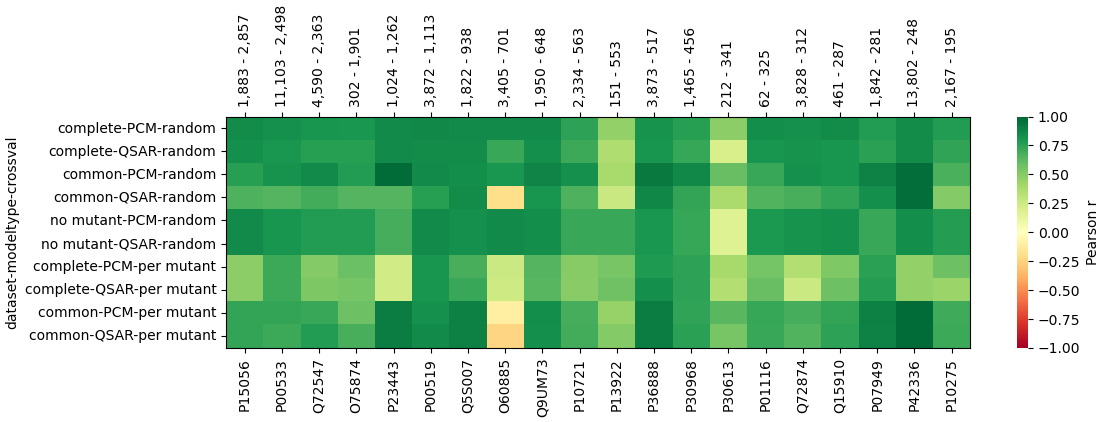

In [33]:
fig, ax = plt.subplots(figsize=(12, 3))

# Plot data
_ = ax.grid(False)
sns.heatmap(data=most_mutant_heatmap.set_index(['dataset', 'modeltype', 'crossval']),
            vmin=-1,
            vmax=1,
            cmap='RdYlGn',
            ax=ax,
            cbar_kws={'label': metrics})

# Obtain x ticklabels in heatmap
xtickslocs = ax.get_xticks()
ymin, _ = ax.get_ylim()
ticks_pos = ax.transData.transform([(xtick, ymin) for xtick in xtickslocs])[:,0]
tick_labels = [xtick.get_text() for xtick in ax.get_xticklabels()]
tick_mapping_most_mutant = pd.concat([pd.Series(ticks_pos, name='x'), pd.Series(tick_labels, name='text')], axis=1)
tick_mapping_most_mutant = tick_mapping_most_mutant.merge(counts, left_on='text', right_on='accession')
tick_mapping_most_mutant.loc[:, 'number'] = [f'{int(tick_mapping_most_mutant.num_datapoints_WT[i]):,} - {int(tick_mapping_most_mutant.num_datapoints_mutants[i]):,}' for i, _ in tick_mapping_most_data.iterrows()]


ax2 = ax.twiny()
_ = ax2.grid(False)
ax2.set_xlim(ax.get_xlim())
_ = ax2.set_xticks(xtickslocs)
_ = ax2.set_xticklabels(tick_mapping_most_mutant.number, rotation=90, va='center', ha='left', rotation_mode='anchor')

### Ordered by highest difference bewteen QSAR and PCM

In [34]:
difference_data = pd.concat([pd.concat([pd.Series(['complete'] * 4, name='dataset'),
                                        (data[(data.subset == 'complete') & (data.folds == 'Mean') & data.contains_mutants]
                                             .drop(columns=[col for col in data.columns
                                                            if col not in [metrics, 'crossval', 'modeltype', 'accession', 'contains_mutants']])
                                             .pivot_table(index=['crossval', 'modeltype', 'contains_mutants'], values='Pearson r', columns='accession')
                                             .reset_index())],
                                      axis=1),
                             pd.concat([pd.Series(['common'] * 4, name='dataset'),
                                        (data[(data.subset == 'common') & (data.folds == 'Mean') & data.contains_mutants]
                                             .drop(columns=[col for col in data.columns
                                                            if col not in [metrics, 'crossval', 'modeltype', 'accession', 'contains_mutants']])
                                             .pivot_table(index=['crossval', 'modeltype', 'contains_mutants'], values='Pearson r', columns='accession')
                                             .reset_index())],
                                      axis=1),
                             pd.concat([pd.Series(['no mutant'] * 2, name='dataset'),
                                        (data[(data.subset == 'complete') & (data.folds == 'Mean') & ~data.contains_mutants]
                                             .drop(columns=[col for col in data.columns
                                                            if col not in [metrics, 'crossval', 'modeltype', 'accession', 'contains_mutants']])
                                             .pivot_table(index=['crossval', 'modeltype', 'contains_mutants'], values='Pearson r', columns='accession')
                                             .reset_index())],
                                      axis=1)
                             ],
                            axis=0)
order_pcm_better = ((difference_data[(difference_data.dataset == 'complete') & (difference_data.modeltype == 'PCM') & (difference_data.crossval == 'random') & difference_data.contains_mutants].iloc[:, 4:].reset_index(drop=True).T -
                     difference_data[(difference_data.dataset == 'complete') & (difference_data.modeltype == 'QSAR') & (difference_data.crossval == 'random') & difference_data.contains_mutants].iloc[:, 4:].reset_index(drop=True).T
                    ).T
                    # .dropna(axis=1)
                    .T.
                    rename(columns={0: 'pearson'})
                    .sort_values('pearson', ascending=False)
                    .index
                    .tolist())
order_qsar_better = ((difference_data[(difference_data.dataset == 'complete') & (difference_data.modeltype == 'PCM') & (difference_data.crossval == 'random') & difference_data.contains_mutants].iloc[:, 4:].reset_index(drop=True).T -
                      difference_data[(difference_data.dataset == 'complete') & (difference_data.modeltype == 'QSAR') & (difference_data.crossval == 'random') & difference_data.contains_mutants].iloc[:, 4:].reset_index(drop=True).T
                      ).T
                     # .dropna(axis=1)
                     .T.
                     rename(columns={0: 'pearson'})
                     .sort_values('pearson', ascending=True)
                     .index
                     .tolist())
# difference_data_pcm = difference_data[['dataset', 'crossval', 'modeltype'] + order_pcm_better].dropna(axis=1).iloc[:, :23]
# difference_data_qsar = difference_data[['dataset', 'crossval', 'modeltype'] + order_qsar_better].dropna(axis=1).iloc[:, :23]
difference_data_pcm = difference_data[['dataset', 'crossval', 'modeltype'] + order_pcm_better].iloc[:, :23]
difference_data_qsar = difference_data[['dataset', 'crossval', 'modeltype'] + order_qsar_better].iloc[:, :23]

difference_data_pcm = (difference_data_pcm.sort_values('modeltype', key=lambda x: x.map({'PCM': 0, 'QSAR': 1}))
                                          .sort_values('dataset', key=lambda x: x.map({'complete': 0, 'common': 1}))
                                          .sort_values('crossval', key=lambda x: x.map({'random': 0, 'per mutant': 1})))
difference_data_qsar = (difference_data_qsar.sort_values('modeltype', key=lambda x: x.map({'PCM': 0, 'QSAR': 1}))
                                            .sort_values('dataset', key=lambda x: x.map({'complete': 0, 'common': 1}))
                                            .sort_values('crossval', key=lambda x: x.map({'random': 0, 'per mutant': 1})))

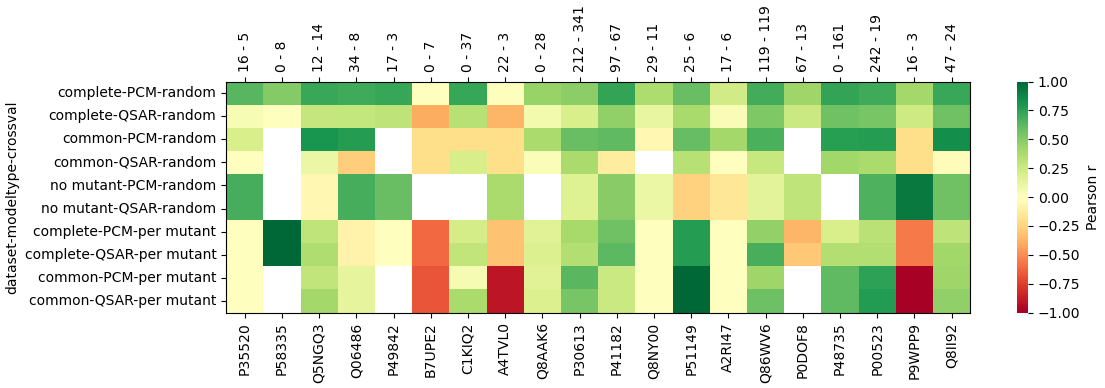

In [35]:
fig, ax = plt.subplots(figsize=(12, 3))

# Plot data
_ = ax.grid(False)
sns.heatmap(data=difference_data_pcm.set_index(['dataset', 'modeltype', 'crossval']),
            vmin=-1,
            vmax=1,
            cmap='RdYlGn',
            ax=ax,
            cbar_kws={'label': metrics})

# Obtain x ticklabels in heatmap
xtickslocs = ax.get_xticks()
ymin, _ = ax.get_ylim()
ticks_pos = ax.transData.transform([(xtick, ymin) for xtick in xtickslocs])[:,0]
tick_labels = [xtick.get_text() for xtick in ax.get_xticklabels()]
tick_mapping_pcm = pd.concat([pd.Series(ticks_pos, name='x'), pd.Series(tick_labels, name='text')], axis=1)
tick_mapping_pcm = tick_mapping_pcm.merge(counts, left_on='text', right_on='accession')
tick_mapping_pcm.loc[:, 'number'] = [f'{int(tick_mapping_pcm.num_datapoints_WT[i]):,} - {int(tick_mapping_pcm.num_datapoints_mutants[i]):,}' for i, _ in tick_mapping_most_data.iterrows()]


ax2 = ax.twiny()
_ = ax2.grid(False)
ax2.set_xlim(ax.get_xlim())
_ = ax2.set_xticks(xtickslocs)
_ = ax2.set_xticklabels(tick_mapping_pcm.number, rotation=90, va='center', ha='left', rotation_mode='anchor')

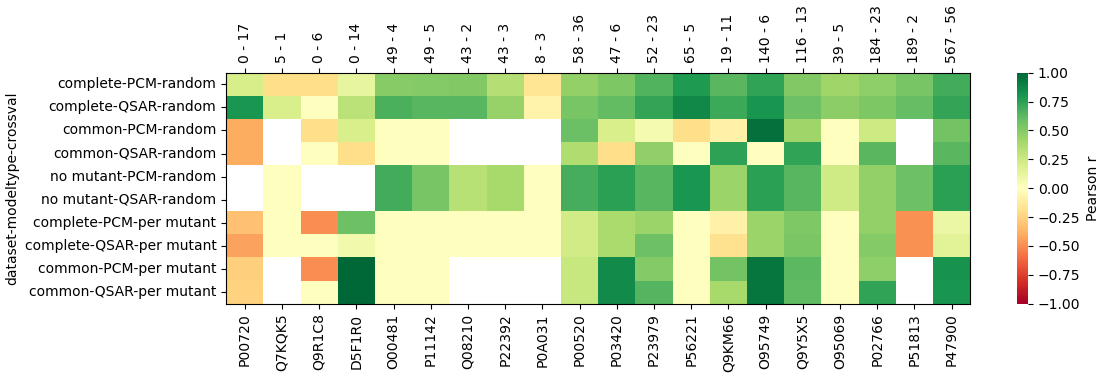

In [36]:
fig, ax = plt.subplots(figsize=(12, 3))

# Plot data
_ = ax.grid(False)
sns.heatmap(data=difference_data_qsar.set_index(['dataset', 'modeltype', 'crossval']),
            vmin=-1,
            vmax=1,
            cmap='RdYlGn',
            ax=ax,
            cbar_kws={'label': metrics})

# Obtain x ticklabels in heatmap
xtickslocs = ax.get_xticks()
ymin, _ = ax.get_ylim()
ticks_pos = ax.transData.transform([(xtick, ymin) for xtick in xtickslocs])[:,0]
tick_labels = [xtick.get_text() for xtick in ax.get_xticklabels()]
tick_mapping_qsar = pd.concat([pd.Series(ticks_pos, name='x'), pd.Series(tick_labels, name='text')], axis=1)
tick_mapping_qsar = tick_mapping_qsar.merge(counts, left_on='text', right_on='accession')
tick_mapping_qsar.loc[:, 'number'] = [f'{int(tick_mapping_qsar.num_datapoints_WT[i]):,} - {int(tick_mapping_qsar.num_datapoints_mutants[i]):,}' for i, _ in tick_mapping_qsar.iterrows()]

ax2 = ax.twiny()
_ = ax2.grid(False)
ax2.set_xlim(ax.get_xlim())
_ = ax2.set_xticks(xtickslocs)
_ = ax2.set_xticklabels(tick_mapping_qsar.number, rotation=90, va='center', ha='left', rotation_mode='anchor')

### Order by most "interesting" (with focus in the manuscript)

In [37]:
most_interesting_prots = counts.query('num_datapoints_total > 1000 and num_datapoints_mutants > 0.1 * num_datapoints_total').reset_index(drop=True)

In [38]:
most_interesting_data = data.merge(most_interesting_prots, on='accession')
most_interesting_data_heatmap = pd.concat([pd.concat([pd.Series(['complete'] * 4, name='dataset'),
                                                      (most_interesting_data[(most_interesting_data.subset == 'complete') & (most_interesting_data.folds == 'Mean') & most_interesting_data.contains_mutants]
                                                       .drop(columns=[col for col in most_interesting_data.columns
                                                                      if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                                       .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                                       .reset_index())],
                                                     axis=1),
                                           pd.concat([pd.Series(['common'] * 4, name='dataset'),
                                                      (most_interesting_data[(most_interesting_data.subset == 'common') & (most_interesting_data.folds == 'Mean') & most_interesting_data.contains_mutants]
                                                       .drop(columns=[col for col in most_interesting_data.columns
                                                                      if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                                       .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                                       .reset_index())],
                                                     axis=1),
                                           pd.concat([pd.Series(['no mutant'] * 2, name='dataset'),
                                                      (most_interesting_data[(most_interesting_data.subset == 'complete') & (most_interesting_data.folds == 'Mean') & ~most_interesting_data.contains_mutants]
                                                       .drop(columns=[col for col in most_interesting_data.columns
                                                                      if col not in [metrics, 'crossval', 'modeltype', 'accession']])
                                                       .pivot_table(index=['crossval', 'modeltype'], values='Pearson r', columns='accession')
                                                       .reset_index())],
                                                     axis=1)
                                           ],
                                          axis=0)
# most_interesting_data_heatmap = most_interesting_data_heatmap.dropna(axis=1)
order_most_interesting = (most_interesting_data[(most_interesting_data.modeltype == 'PCM') & (most_interesting_data.crossval == 'random') & (most_interesting_data.folds == 'Mean') & (most_interesting_data.subset == 'complete') & most_interesting_data.contains_mutants & most_interesting_data.accession.isin(most_interesting_data_heatmap.columns)]
                          .sort_values('number', ascending=False)
                          .accession
                          .tolist())
most_interesting_data_heatmap = most_interesting_data_heatmap[['dataset', 'crossval', 'modeltype'] + order_most_interesting]
most_interesting_data_heatmap = (most_interesting_data_heatmap.sort_values('modeltype', key=lambda x: x.map({'PCM': 0, 'QSAR': 1}))
                            .sort_values('dataset', key=lambda x: x.map({'complete': 0, 'common': 1}))
                            .sort_values('crossval', key=lambda x: x.map({'random': 0, 'per mutant': 1})))
most_interesting_data_heatmap = most_interesting_data_heatmap.reset_index(drop=True)

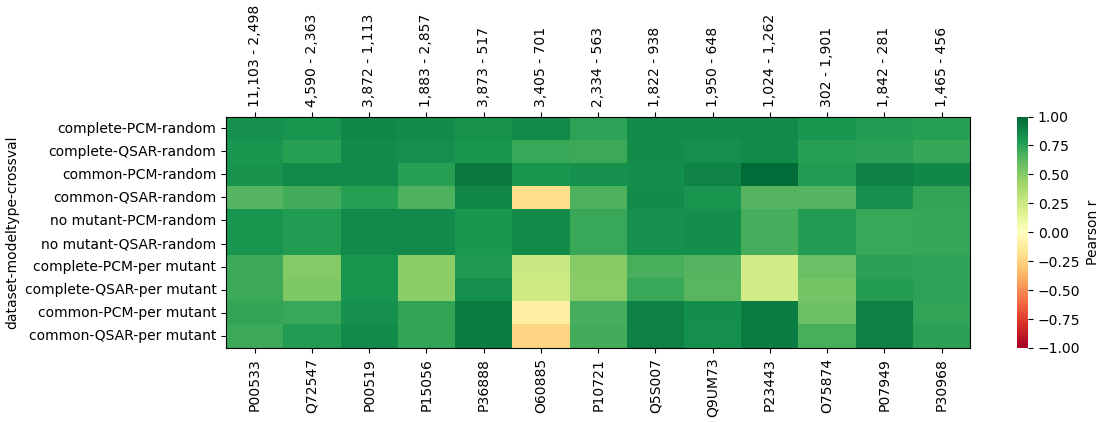

In [39]:
fig, ax = plt.subplots(figsize=(12, 3))

# Plot data
_ = ax.grid(False)
sns.heatmap(data=most_interesting_data_heatmap.set_index(['dataset', 'modeltype', 'crossval']),
            vmin=-1,
            vmax=1,
            cmap='RdYlGn',
            ax=ax,
            cbar_kws={'label': metrics})

# Obtain x ticklabels in heatmap
xtickslocs = ax.get_xticks()
ymin, _ = ax.get_ylim()
ticks_pos = ax.transData.transform([(xtick, ymin) for xtick in xtickslocs])[:,0]
tick_labels = [xtick.get_text() for xtick in ax.get_xticklabels()]
tick_mapping_most_interesting_data = pd.concat([pd.Series(ticks_pos, name='x'), pd.Series(tick_labels, name='text')], axis=1)
tick_mapping_most_interesting_data = tick_mapping_most_interesting_data.merge(counts, left_on='text', right_on='accession')
tick_mapping_most_interesting_data.loc[:, 'number'] = [f'{int(tick_mapping_most_interesting_data.num_datapoints_WT[i]):,} - {int(tick_mapping_most_interesting_data.num_datapoints_mutants[i]):,}' for i, _ in tick_mapping_most_interesting_data.iterrows()]

ax2 = ax.twiny()
_ = ax2.grid(False)
ax2.set_xlim(ax.get_xlim())
_ = ax2.set_xticks(xtickslocs)
_ = ax2.set_xticklabels(tick_mapping_most_interesting_data.number, rotation=90, va='center', ha='left', rotation_mode='anchor')

## Complex Heatmaps

Increase font scale to save plots on disk.

In [40]:
sns.set(font_scale=2.5, rc={'text.usetex' : False}, style="whitegrid")

Define folder to store figures in.

### Ordered by highest difference bewteen QSAR and PCM

#### Cases where QSAR better than PCM

In [41]:
difference_data_qsar = difference_data_qsar.reset_index(drop=True)

In [42]:
tick_mapping_qsar['mutant_fraction'] = tick_mapping_qsar.num_datapoints_mutants / tick_mapping_qsar.num_datapoints_total * 100
tick_mapping_qsar['WT_fraction'] = 100 - tick_mapping_qsar.mutant_fraction

The following plot shows the general look of the complex heatmap figures that will be created from the plot under. 

Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


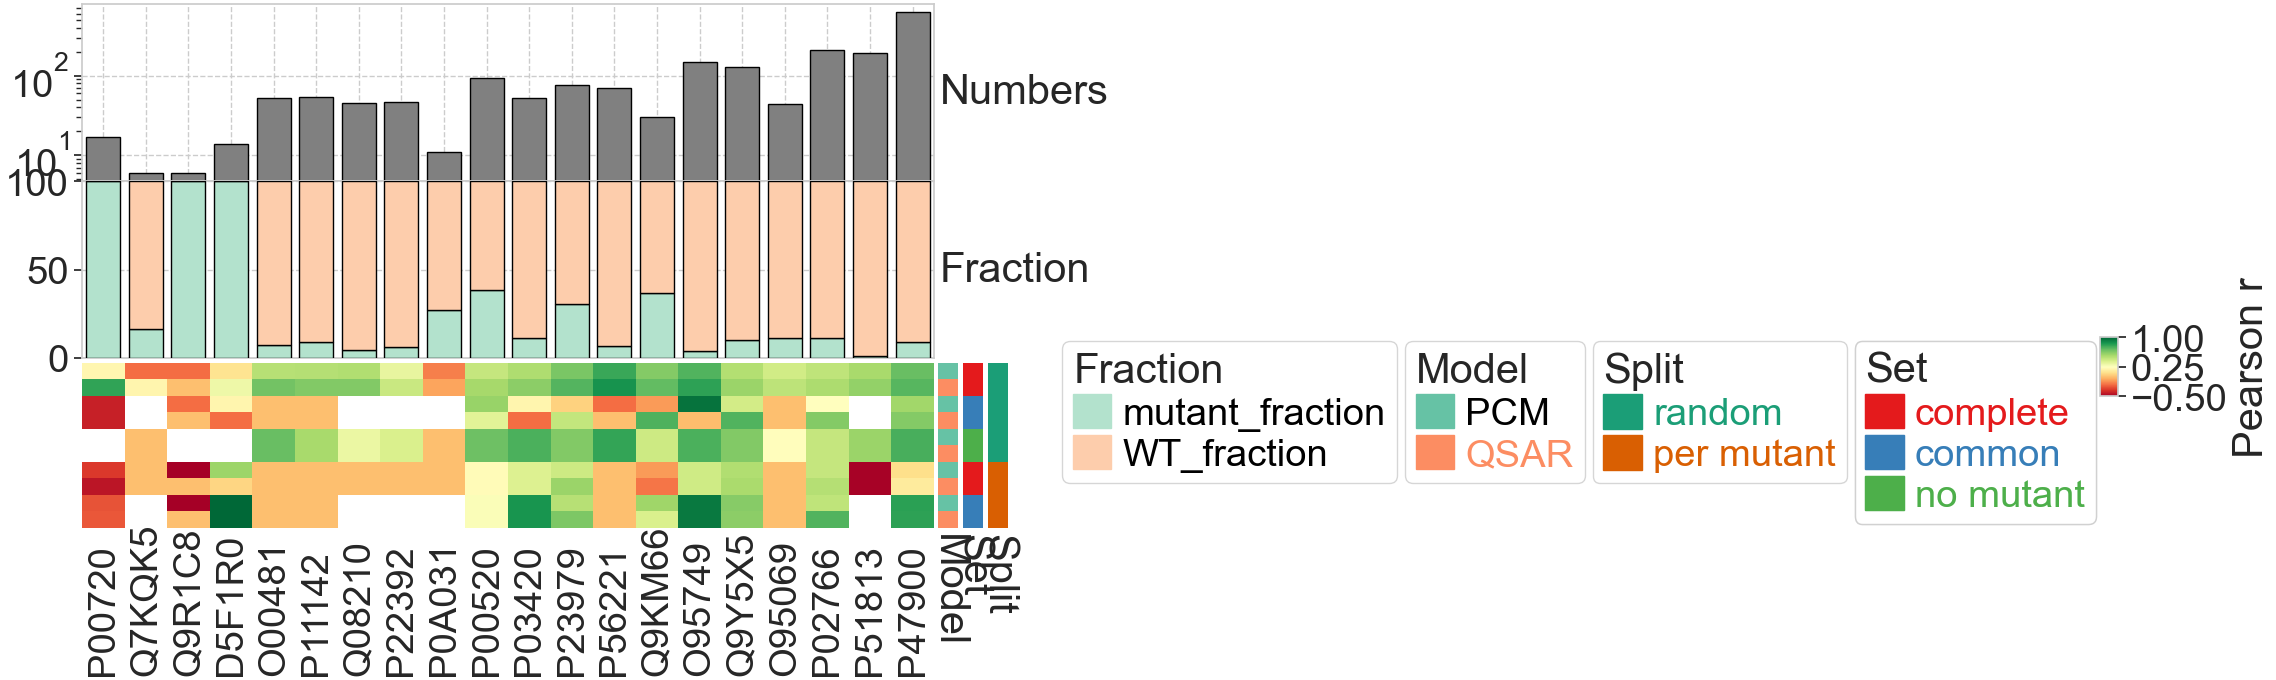

In [43]:
row_ha = HeatmapAnnotation(Model=anno_simple(difference_data_qsar.modeltype, legend=True, cmap='Set2', height=6),
                           Set=anno_simple(difference_data_qsar.dataset, legend=True, cmap='Set1', height=6),
                           Split=anno_simple(difference_data_qsar.crossval, legend=True, cmap='Dark2', height=6),
                           label_side='bottom', axis=0, wgap=1.5, orientation='right', verbose=False)

col_ha = HeatmapAnnotation(Numbers=anno_barplot(tick_mapping_qsar.set_index('text')[['num_datapoints_total']],
                                                log=True,
                                                height=40,
                                                colors='grey'
                                                ),
                           Fraction=anno_barplot(tick_mapping_qsar.set_index('text')[['mutant_fraction', 'WT_fraction']],
                                                height=40,
                                                cmap='Pastel2',
                                                ), verbose=False)
plt.figure(figsize=(12, 6))
cm = ClusterMapPlotter(data=difference_data_qsar.iloc[:, 3:], right_annotation=row_ha, top_annotation=col_ha,
                       show_rownames=False, show_colnames=True, #row_names_side='left',
                       #col_split=df_cols.Family,
                       cmap='RdYlGn', label='Pearson r',
                       #rasterized=True,
                       legend=True,
                       legend_anchor='ax_heatmap',
                       legend_width=60,
                       legend_hpad=30,
                       row_cluster=False,
                       col_cluster=False,
                       xticklabels_kws={'labelrotation':90, 'pad': 100},
                       verbose=False)
plt.show()

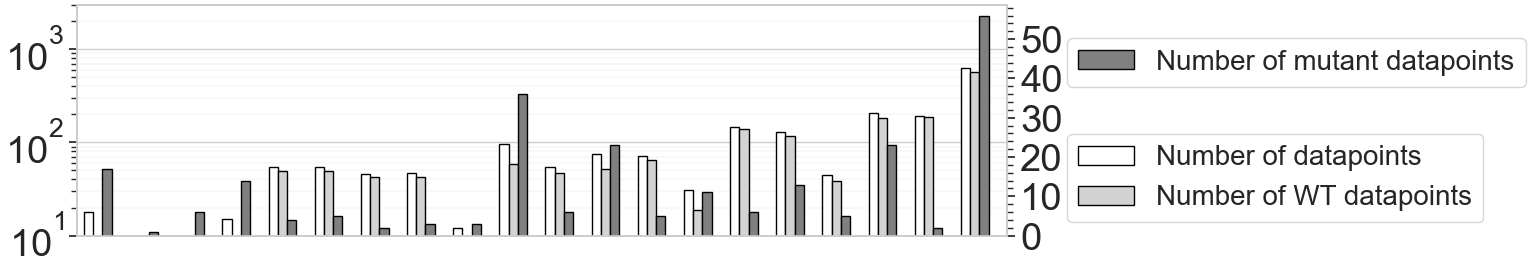

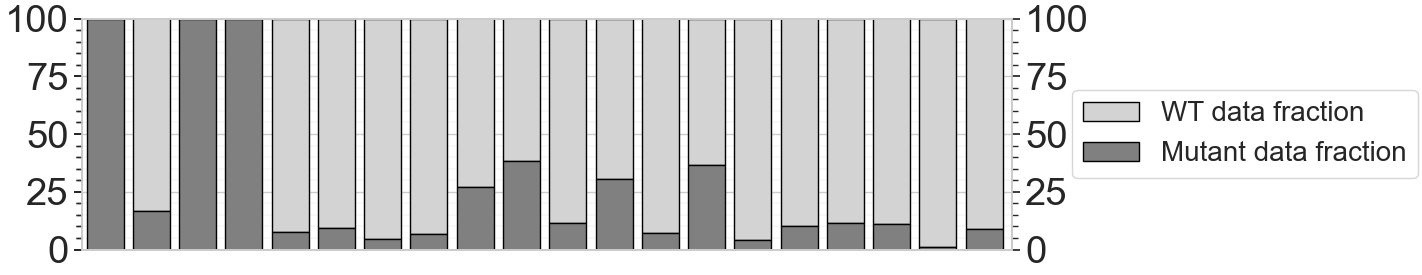

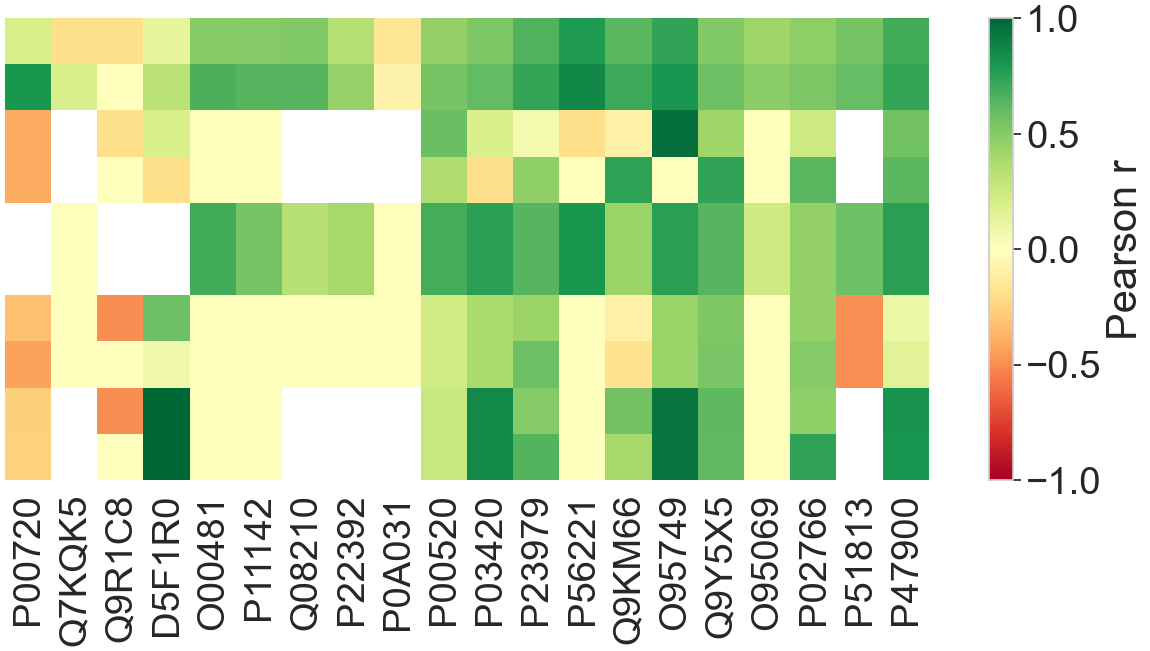

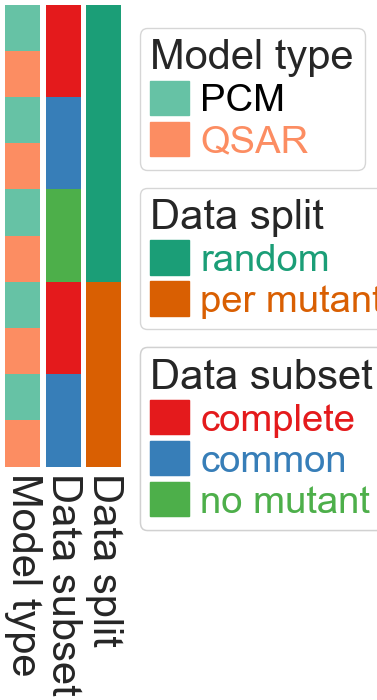

In [44]:
fig, ax = plt.subplots(figsize=(12, 3))
ax2 = ax.twinx()
tick_mapping_qsar['num_datapoints_total'].plot(kind='bar', ax=ax, position=2, color='white', edgecolor='black', label='Number of datapoints', log=True, width=0.2)
tick_mapping_qsar['num_datapoints_WT'].plot(kind='bar', ax=ax, position=1, color='lightgray', edgecolor='black', label='Number of WT datapoints', log=True, width=0.2)
tick_mapping_qsar['num_datapoints_mutants'].plot(kind='bar',ax=ax2, position=0,  color='#808080', edgecolor='black', label='Number of mutant datapoints', width=0.2)
ax2.yaxis.grid(False)
ax.set_xticks([])
ax.set_ylim((10, 3000))
ax.set_xlim((-0.55, tick_mapping_qsar.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000]))
ax.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.25), prop={'size': 20})
ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.75), prop={'size': 20})
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', right=True)
ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_minor_locator(MultipleLocator(2))
ax2.grid(False, which='minor')
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.QSAR_better_than_PCM.QSAR_best.elem1.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(x=tick_mapping_qsar['text'], height=tick_mapping_qsar['WT_fraction'],
       bottom=tick_mapping_qsar['mutant_fraction'],
       color='lightgray', edgecolor='black', label='WT data fraction')
ax.bar(x=tick_mapping_qsar['text'], height=tick_mapping_qsar['mutant_fraction'],
       color='#808080', edgecolor='black', label='Mutant data fraction')
ax.set_xticks([])
ax.set_ylim((0, 100))
ax.set_xlim((-0.5, tick_mapping_qsar.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.grid(False)
ax.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
ax2.set_ylim((0, 100))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', left=True)
ax2.grid(False, axis='y', which='both')
ax2.yaxis.set_major_locator(MultipleLocator(25))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.QSAR_better_than_PCM.QSAR_best.elem2.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(difference_data_qsar.iloc[:, 3:], vmin=-1, vmax=1, cmap=colormaps.get_cmap('RdYlGn')) #LinearSegmentedColormap.from_list("", ["#D43B61", "#FAE3D1","white", "#CDE8D3","#34ADAB"])
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax, label='Pearson r')
_ = ax.set_xticks(np.arange(difference_data_qsar.iloc[:, 3:].shape[1]), labels=difference_data_qsar.iloc[:, 3:].columns,
                  rotation=90,rotation_mode="anchor", ha='right', va='center')
_ = ax.get_yaxis().set_ticks([])
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.QSAR_better_than_PCM.QSAR_best.elem3.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(1.5, 6))
row_ha = HeatmapAnnotation(**{'Model type': anno_simple(difference_data_qsar.modeltype, legend=True,cmap='Set2', height=6)}, # ListedColormap(['#C11F1D', '#88E99A'])
                           **{'Data subset': anno_simple(difference_data_qsar.dataset, legend=True, cmap='Set1', height=6)}, # ListedColormap(['#FF8800', '#19A6EE', '#019C00'])
                           **{'Data split': anno_simple(difference_data_qsar.crossval, legend=True, cmap='Dark2', height=6)}, # ListedColormap(['#FEC502', '#4328E7'])
                           label_side='bottom', axis=0, wgap=1.5, orientation='right', plot=True, verbose=False,
                           legend_width=60)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.QSAR_better_than_PCM.QSAR_best.elem4.svg'))
# plt.show()

#### Cases where QSAR better than PCM

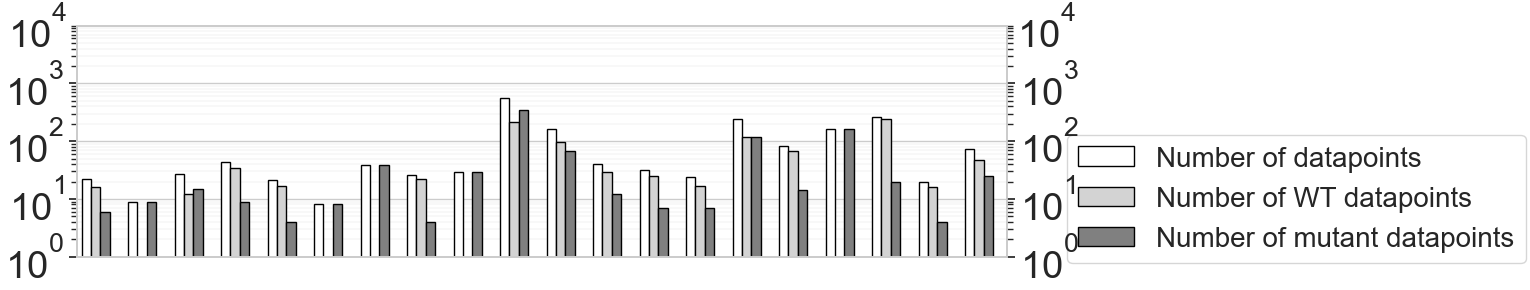

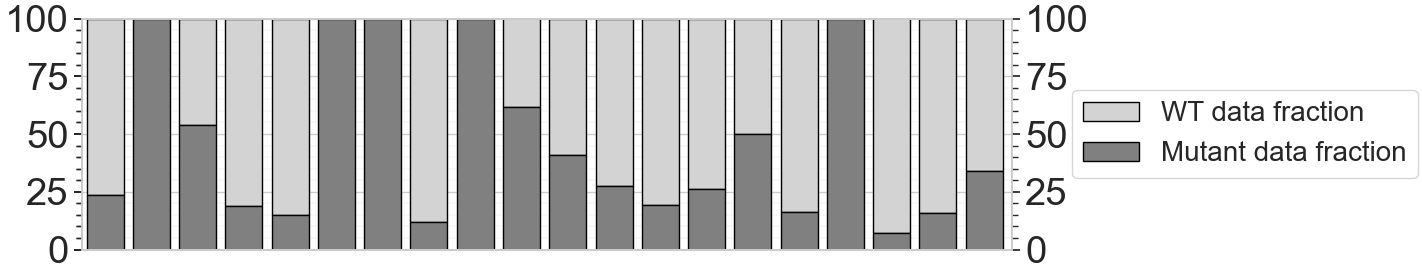

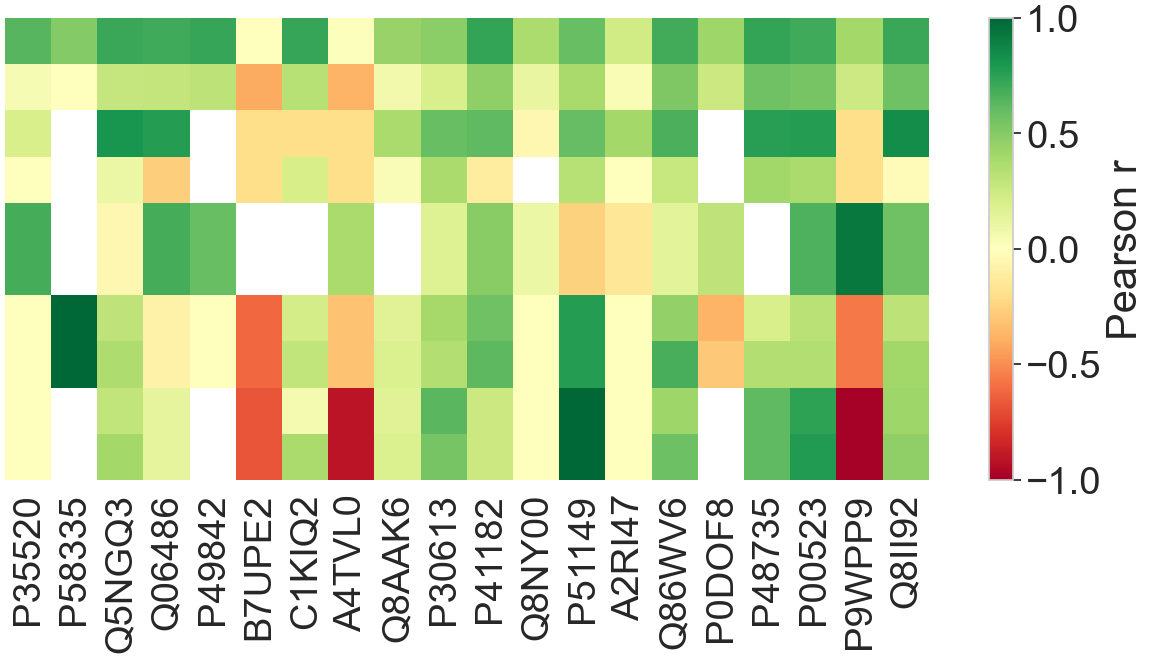

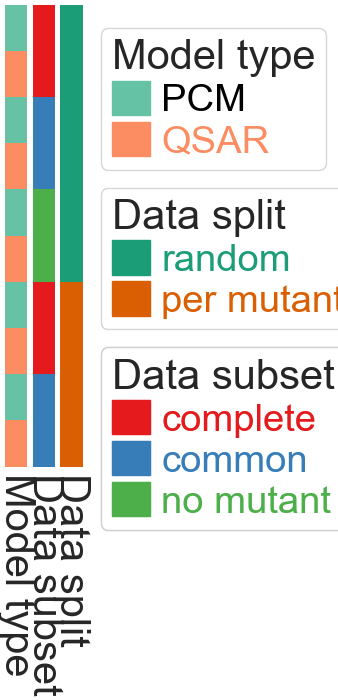

In [45]:
difference_data_pcm = difference_data_pcm.reset_index(drop=True)
tick_mapping_pcm['mutant_fraction'] = tick_mapping_pcm.num_datapoints_mutants / tick_mapping_pcm.num_datapoints_total * 100
tick_mapping_pcm['total_fraction'] = 100 - tick_mapping_pcm.mutant_fraction
fig, ax = plt.subplots(figsize=(12, 3))
tick_mapping_pcm['num_datapoints_total'].plot(kind='bar', ax=ax, position=2, color='white', edgecolor='black', label='Number of datapoints', log=True, width=0.2)
tick_mapping_pcm['num_datapoints_WT'].plot(kind='bar', ax=ax, position=1, color='lightgray', edgecolor='black', label='Number of WT datapoints', log=True, width=0.2)
tick_mapping_pcm['num_datapoints_mutants'].plot(kind='bar',ax=ax, position=0,  color='#808080', edgecolor='black', label='Number of mutant datapoints', log=True, width=0.2)
ax.set_xticks([])
ax.set_ylim((1, 10000))
ax.set_xlim((-0.5, tick_mapping_pcm.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000]))
ax.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax.xaxis.grid(False)
plt.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.25), prop={'size': 20})
ax2 = ax.twinx()
tick_mapping_pcm['num_datapoints_total'].plot(kind='bar', ax=ax2, alpha=0.0, log=True)
ax2.set_ylim((1, 10000))
ax2.yaxis.grid(False)
ax2.minorticks_on()
ax2.set_xticks([])
ax2.tick_params(axis='y', which='both', right=True)
ax2.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000]))
ax2.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax2.grid(False, which='minor')
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.PCM_better_than_QSAR.elem1.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(x=tick_mapping_pcm['text'], height=tick_mapping_pcm['total_fraction'],
       bottom=tick_mapping_pcm['mutant_fraction'],
       color='lightgray', edgecolor='black', label='WT data fraction')
ax.bar(x=tick_mapping_pcm['text'], height=tick_mapping_pcm['mutant_fraction'],
       color='#808080', edgecolor='black', label='Mutant data fraction')
ax.set_xticks([])
ax.set_ylim((0, 100))
ax.set_xlim((-0.5, tick_mapping_pcm.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.grid(False)
ax.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
ax2.set_ylim((0, 100))
ax2.minorticks_on()
ax2.set_xticks([])
ax2.tick_params(axis='y', which='both', left=True)
ax2.grid(False, axis='y', which='both')
ax2.yaxis.set_major_locator(MultipleLocator(25))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.PCM_better_than_QSAR.elem2.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(difference_data_pcm.iloc[:, 3:], vmin=-1, vmax=1, cmap=colormaps.get_cmap('RdYlGn')) #LinearSegmentedColormap.from_list("", ["#D43B61", "#FAE3D1","white", "#CDE8D3","#34ADAB"])
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax, label='Pearson r')
_ = ax.set_xticks(np.arange(difference_data_pcm.iloc[:, 3:].shape[1]), labels=difference_data_pcm.iloc[:, 3:].columns,
                  rotation=90,rotation_mode="anchor", ha='right', va='center')
_ = ax.get_yaxis().set_ticks([])
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.PCM_better_than_QSAR.elem3.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(1, 6))
row_ha = HeatmapAnnotation(**{'Model type': anno_simple(difference_data_pcm.modeltype, legend=True, cmap='Set2', height=6)},
                           **{'Data subset': anno_simple(difference_data_pcm.dataset, legend=True, cmap='Set1', height=6)},
                           **{'Data split': anno_simple(difference_data_pcm.crossval, legend=True, cmap='Dark2', height=6)},
                           label_side='bottom', axis=0, wgap=1.5, orientation='right', plot=True, verbose=False,
                           legend_width=60)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.PCM_better_than_QSAR.elem4.svg'))
# plt.show()


### Order accessions by the amount of data points

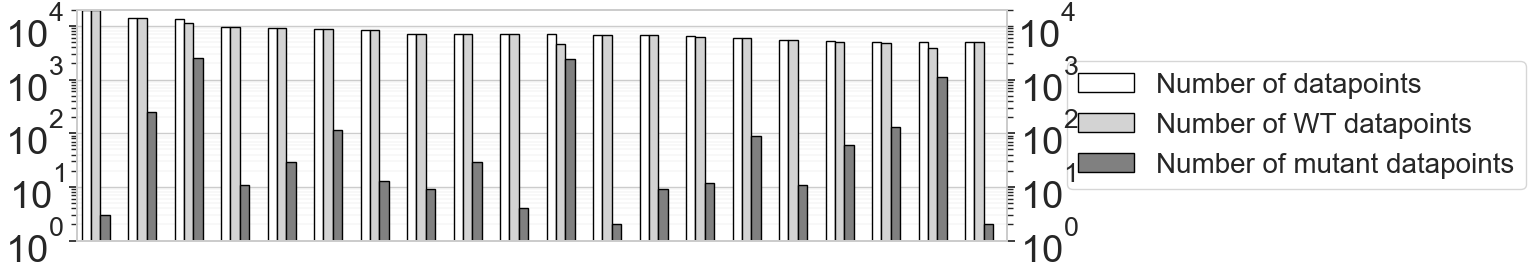

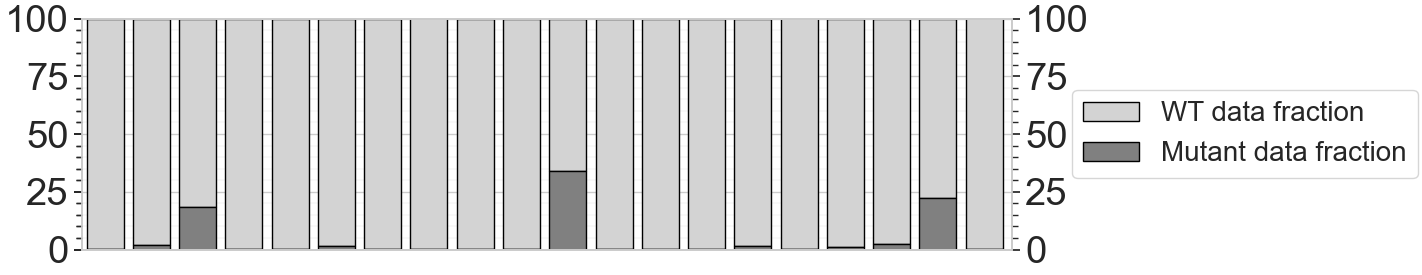

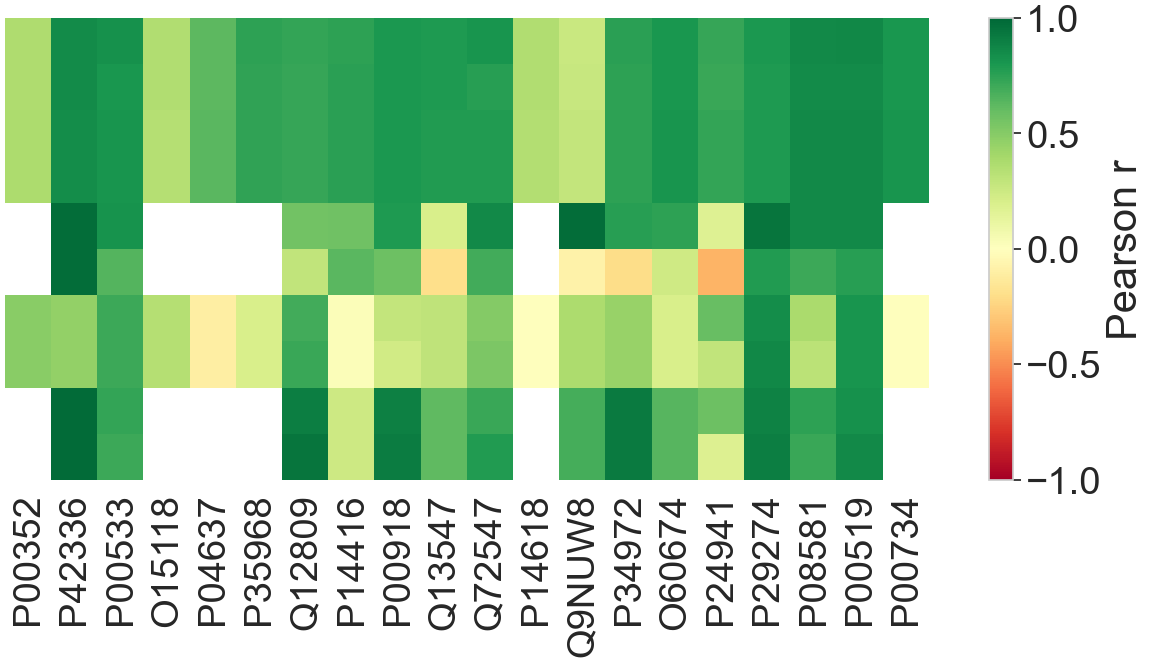

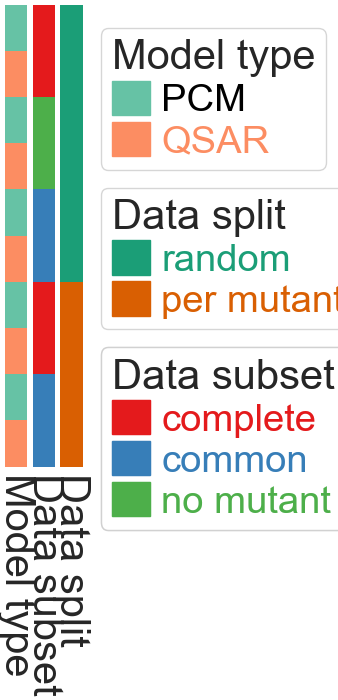

In [46]:
heatmap_data = heatmap_data.reset_index(drop=True)
tick_mapping_most_data['mutant_fraction'] = tick_mapping_most_data.num_datapoints_mutants / tick_mapping_most_data.num_datapoints_total * 100
tick_mapping_most_data['total_fraction'] = 100 - tick_mapping_most_data.mutant_fraction

fig, ax = plt.subplots(figsize=(12, 3))
tick_mapping_most_data['num_datapoints_total'].plot(kind='bar', ax=ax, position=2, color='white', edgecolor='black', label='Number of datapoints', log=True, width=0.2)
tick_mapping_most_data['num_datapoints_WT'].plot(kind='bar', ax=ax, position=1, color='lightgray', edgecolor='black', label='Number of WT datapoints', log=True, width=0.2)
tick_mapping_most_data['num_datapoints_mutants'].plot(kind='bar',ax=ax, position=0,  color='#808080', edgecolor='black', label='Number of mutant datapoints', log=True, width=0.2)
ax.set_xticks([])
ax.set_ylim((1, 20_000))
ax.set_xlim((-0.5, tick_mapping_most_data.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000, 10000]))
ax.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax.xaxis.grid(False)
plt.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
tick_mapping_most_data['num_datapoints_total'].plot(kind='bar', ax=ax2, alpha=0.0, log=True)
ax2.yaxis.grid(False)
ax2.set_xticks([])
ax2.set_ylim((1, 20_000))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', right=True)
ax2.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000]))
ax2.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax2.grid(False, which='minor')
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_data.elem1.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(x=tick_mapping_most_data['text'], height=tick_mapping_most_data['total_fraction'],
       bottom=tick_mapping_most_data['mutant_fraction'],
       color='lightgray', edgecolor='black', label='WT data fraction')
ax.bar(x=tick_mapping_most_data['text'], height=tick_mapping_most_data['mutant_fraction'],
       color='#808080', edgecolor='black', label='Mutant data fraction')
ax.set_xticks([])
ax.set_ylim((0, 100))
ax.set_xlim((-0.5, tick_mapping_most_data.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.grid(False)
ax.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
ax2.set_ylim((0, 100))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', left=True)
ax2.grid(False, axis='y', which='both')
ax2.yaxis.set_major_locator(MultipleLocator(25))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_data.elem2.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(heatmap_data.iloc[:, 3:], vmin=-1, vmax=1, cmap=colormaps.get_cmap('RdYlGn')) #LinearSegmentedColormap.from_list("", ["#D43B61", "#FAE3D1","white", "#CDE8D3","#34ADAB"])
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax, label='Pearson r')
_ = ax.set_xticks(np.arange(heatmap_data.iloc[:, 3:].shape[1]), labels=heatmap_data.iloc[:, 3:].columns,
                  rotation=90,rotation_mode="anchor", ha='right', va='center')
_ = ax.get_yaxis().set_ticks([])
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_data.elem3.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(1, 6))
row_ha = HeatmapAnnotation(**{'Model type': anno_simple(heatmap_data.modeltype, legend=True, cmap='Set2', height=6)},
                           **{'Data subset': anno_simple(heatmap_data.dataset, legend=True, cmap='Set1', height=6)},
                           **{'Data split': anno_simple(heatmap_data.crossval, legend=True, cmap='Dark2', height=6)},
                           label_side='bottom', axis=0, wgap=1.5, orientation='right', plot=True, verbose=False,
                           legend_width=60)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_data.elem4.svg'))
plt.show()

### Order accession by highest mutant to WT ratio

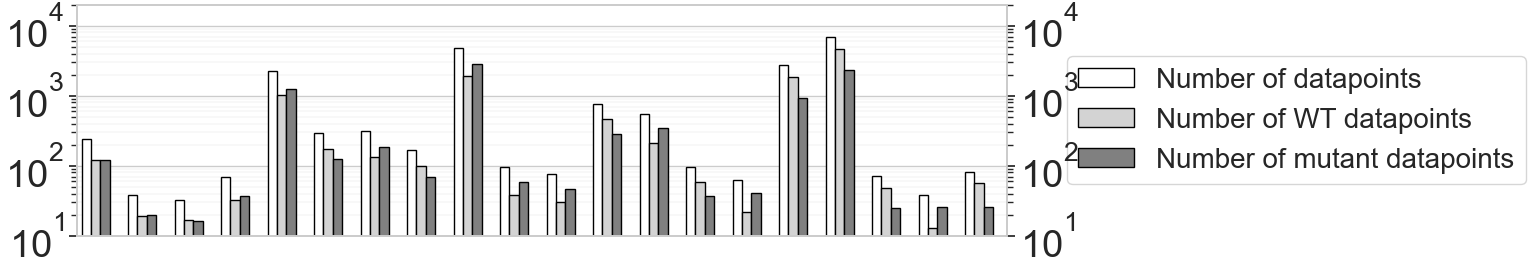

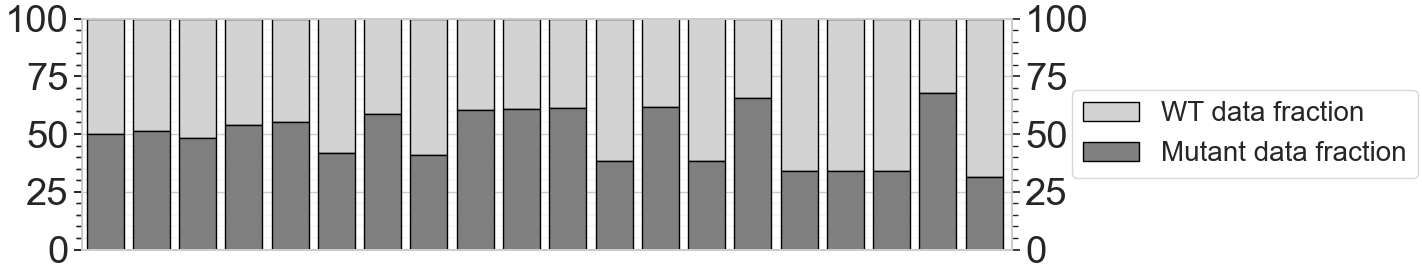

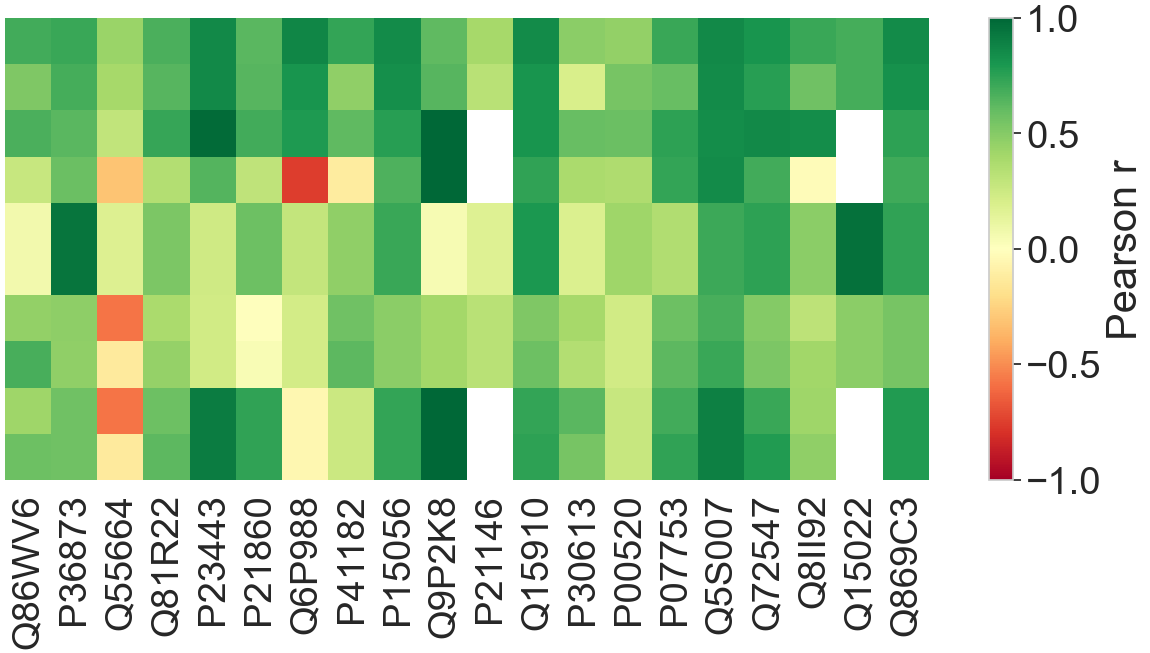

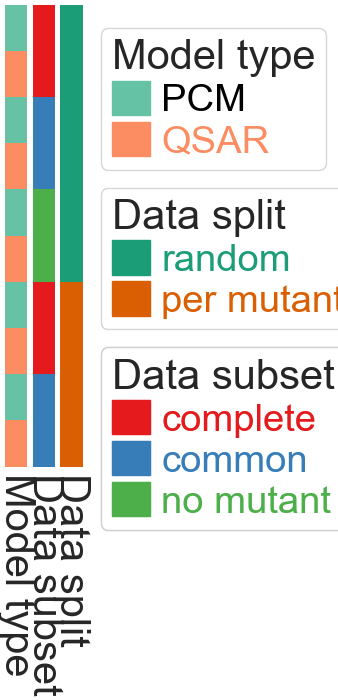

In [47]:
ratio_heatmap = ratio_heatmap.reset_index(drop=True)
tick_mapping_ratio['mutant_fraction'] = tick_mapping_ratio.num_datapoints_mutants / tick_mapping_ratio.num_datapoints_total * 100
tick_mapping_ratio['total_fraction'] = 100 - tick_mapping_ratio.mutant_fraction

fig, ax = plt.subplots(figsize=(12, 3))
tick_mapping_ratio['num_datapoints_total'].plot(kind='bar', ax=ax, position=2, color='white', edgecolor='black', label='Number of datapoints', log=True, width=0.2)
tick_mapping_ratio['num_datapoints_WT'].plot(kind='bar', ax=ax, position=1, color='lightgray', edgecolor='black', label='Number of WT datapoints', log=True, width=0.2)
tick_mapping_ratio['num_datapoints_mutants'].plot(kind='bar',ax=ax, position=0,  color='#808080', edgecolor='black', label='Number of mutant datapoints', log=True, width=0.2)
ax.set_xticks([])
ax.set_ylim((10, 20_000))
ax.set_xlim((-0.5, tick_mapping_ratio.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000, 10000]))
ax.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax.xaxis.grid(False)
ax.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
tick_mapping_ratio['num_datapoints_total'].plot(kind='bar', ax=ax2, alpha=0.0, log=True)
ax2.yaxis.grid(False)
ax2.set_ylim((10, 20_000))
ax.set_xticks([])
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', right=True)
ax2.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000, 10000]))
ax2.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax2.grid(False, which='minor')
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_balanced_mutant_data.elem1.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(x=tick_mapping_ratio['text'], height=tick_mapping_ratio['total_fraction'],
       bottom=tick_mapping_ratio['mutant_fraction'],
       color='lightgray', edgecolor='black', label='WT data fraction')
ax.bar(x=tick_mapping_ratio['text'], height=tick_mapping_ratio['mutant_fraction'],
       color='#808080', edgecolor='black', label='Mutant data fraction')
ax.set_xticks([])
ax.set_ylim((0, 100))
ax.set_xlim((-0.5, tick_mapping_ratio.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.grid(False)
ax.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
ax2.set_ylim((0, 100))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', left=True)
ax2.grid(False, axis='y', which='both')
ax2.yaxis.set_major_locator(MultipleLocator(25))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_balanced_mutant_data.elem2.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(ratio_heatmap.iloc[:, 3:], vmin=-1, vmax=1, cmap=colormaps.get_cmap('RdYlGn')) #LinearSegmentedColormap.from_list("", ["#D43B61", "#FAE3D1","white", "#CDE8D3","#34ADAB"])
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax, label='Pearson r')
_ = ax.set_xticks(np.arange(ratio_heatmap.iloc[:, 3:].shape[1]), labels=ratio_heatmap.iloc[:, 3:].columns,
                  rotation=90,rotation_mode="anchor", ha='right', va='center')
_ = ax.get_yaxis().set_ticks([])
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_balanced_mutant_data.elem3.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(1, 6))
row_ha = HeatmapAnnotation(**{'Model type': anno_simple(ratio_heatmap.modeltype, legend=True, cmap='Set2', height=6)},
                           **{'Data subset': anno_simple(ratio_heatmap.dataset, legend=True, cmap='Set1', height=6)},
                           **{'Data split': anno_simple(ratio_heatmap.crossval, legend=True, cmap='Dark2', height=6)},
                           label_side='bottom', axis=0, wgap=1.5, orientation='right', plot=True, verbose=False,
                           legend_width=60)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_balanced_mutant_data.elem4.svg'))
plt.show()

### Ordered by accessions with most data points related to mutant

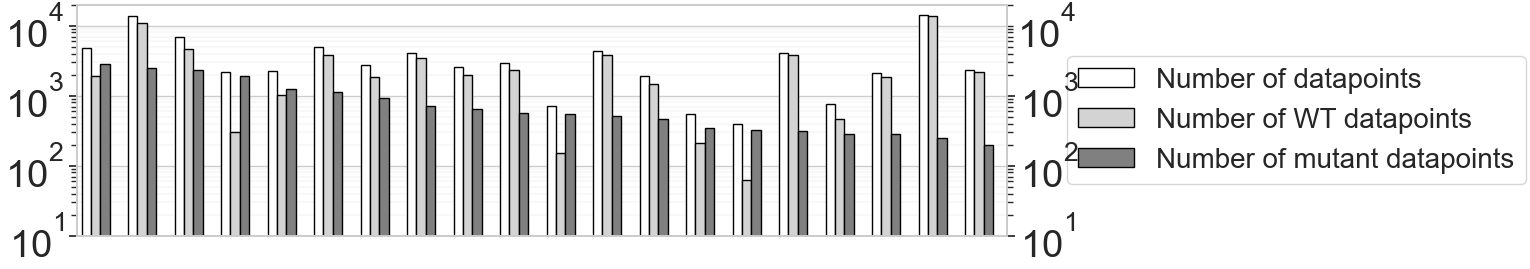

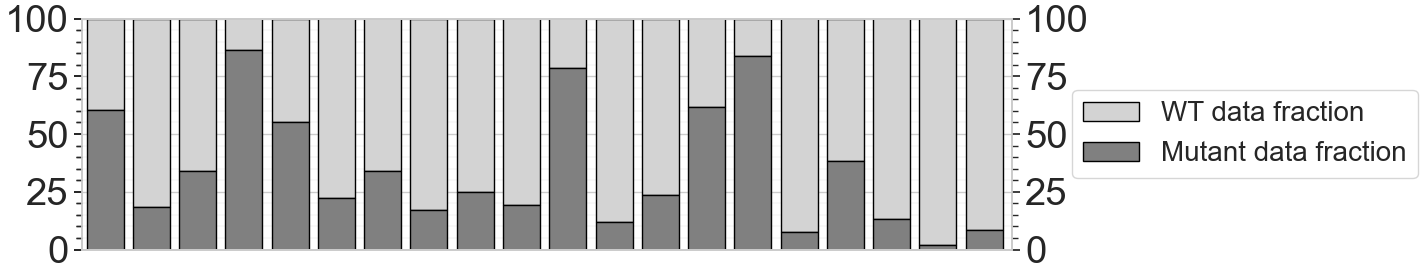

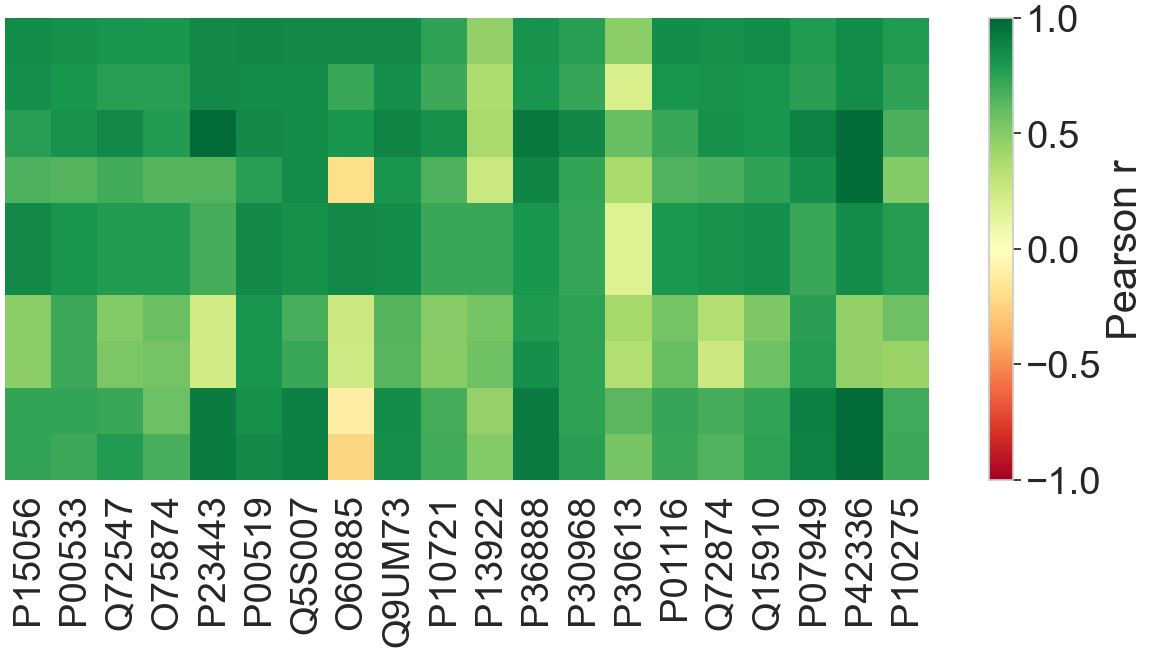

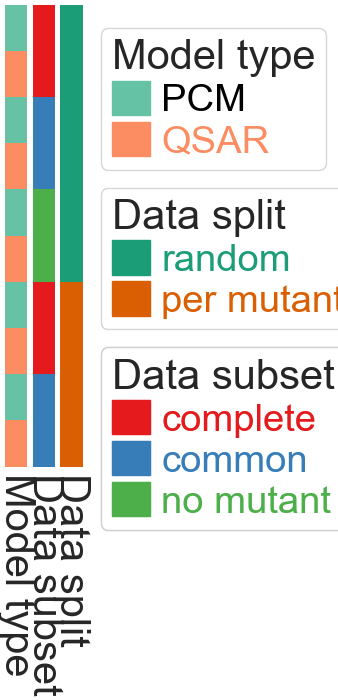

In [48]:
most_mutant_heatmap = most_mutant_heatmap.reset_index(drop=True)
tick_mapping_most_mutant['mutant_fraction'] = tick_mapping_most_mutant.num_datapoints_mutants / tick_mapping_most_mutant.num_datapoints_total * 100
tick_mapping_most_mutant['total_fraction'] = 100 - tick_mapping_most_mutant.mutant_fraction

fig, ax = plt.subplots(figsize=(12, 3))
tick_mapping_most_mutant['num_datapoints_total'].plot(kind='bar', ax=ax, position=2, color='white', edgecolor='black', label='Number of datapoints', log=True, width=0.2)
tick_mapping_most_mutant['num_datapoints_WT'].plot(kind='bar', ax=ax, position=1, color='lightgray', edgecolor='black', label='Number of WT datapoints', log=True, width=0.2)
tick_mapping_most_mutant['num_datapoints_mutants'].plot(kind='bar',ax=ax, position=0,  color='#808080', edgecolor='black', label='Number of mutant datapoints', log=True, width=0.2)
ax.set_xticks([])
ax.set_ylim((10, 20_000))
ax.set_xlim((-0.5, tick_mapping_most_mutant.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000, 10000]))
ax.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax.xaxis.grid(False)
plt.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
tick_mapping_most_mutant['num_datapoints_total'].plot(kind='bar', ax=ax2, alpha=0.0, log=True)
ax2.yaxis.grid(False)
ax2.set_ylim((10, 20_000))
ax2.set_xticks([])
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', right=True)
ax2.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000]))
ax2.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax2.grid(False, which='minor')
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_mutant_data.elem1.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(x=tick_mapping_most_mutant['text'], height=tick_mapping_most_mutant['total_fraction'],
       bottom=tick_mapping_most_mutant['mutant_fraction'],
       color='lightgray', edgecolor='black', label='WT data fraction')
ax.bar(x=tick_mapping_most_mutant['text'], height=tick_mapping_most_mutant['mutant_fraction'],
       color='#808080', edgecolor='black', label='Mutant data fraction')
ax.set_xticks([])
ax.set_ylim((0, 100))
ax.set_xlim((-0.5, tick_mapping_most_mutant.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.grid(False)
ax.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
ax2.set_ylim((0, 100))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', left=True)
ax2.grid(False, axis='y', which='both')
ax2.yaxis.set_major_locator(MultipleLocator(25))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_mutant_data.elem2.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(most_mutant_heatmap.iloc[:, 3:], vmin=-1, vmax=1, cmap=colormaps.get_cmap('RdYlGn')) #LinearSegmentedColormap.from_list("", ["#D43B61", "#FAE3D1","white", "#CDE8D3","#34ADAB"])
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax, label='Pearson r')
_ = ax.set_xticks(np.arange(most_mutant_heatmap.iloc[:, 3:].shape[1]), labels=most_mutant_heatmap.iloc[:, 3:].columns,
                  rotation=90,rotation_mode="anchor", ha='right', va='center')
_ = ax.get_yaxis().set_ticks([])
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_mutant_data.elem3.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(1, 6))
row_ha = HeatmapAnnotation(**{'Model type': anno_simple(most_mutant_heatmap.modeltype, legend=True, cmap='Set2', height=6)},
                           **{'Data subset': anno_simple(most_mutant_heatmap.dataset, legend=True, cmap='Set1', height=6)},
                           **{'Data split': anno_simple(most_mutant_heatmap.crossval, legend=True, cmap='Dark2', height=6)},
                           label_side='bottom', axis=0, wgap=1.5, orientation='right', plot=True, verbose=False,
                           legend_width=60)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_mutant_data.elem4.svg'))
plt.show()

### Order by most "interesting" (with focus in the manuscript)

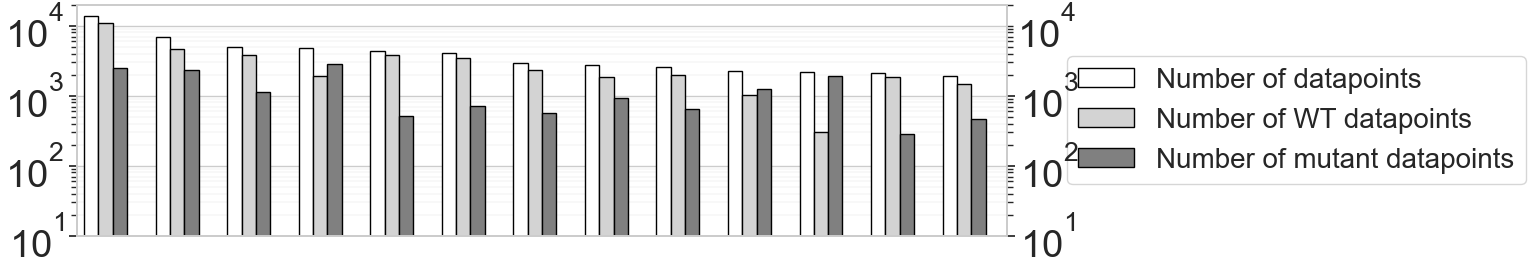

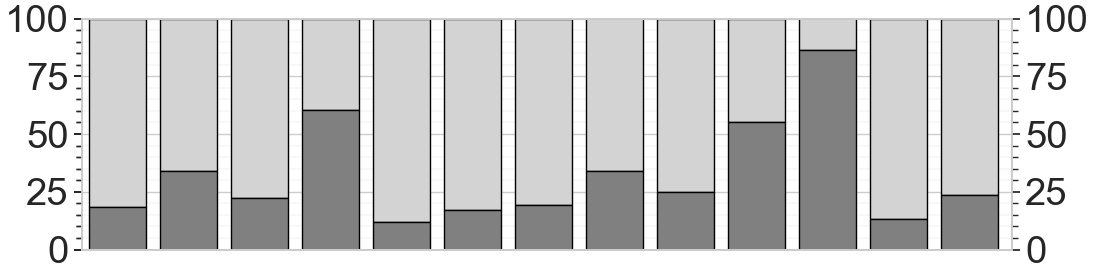

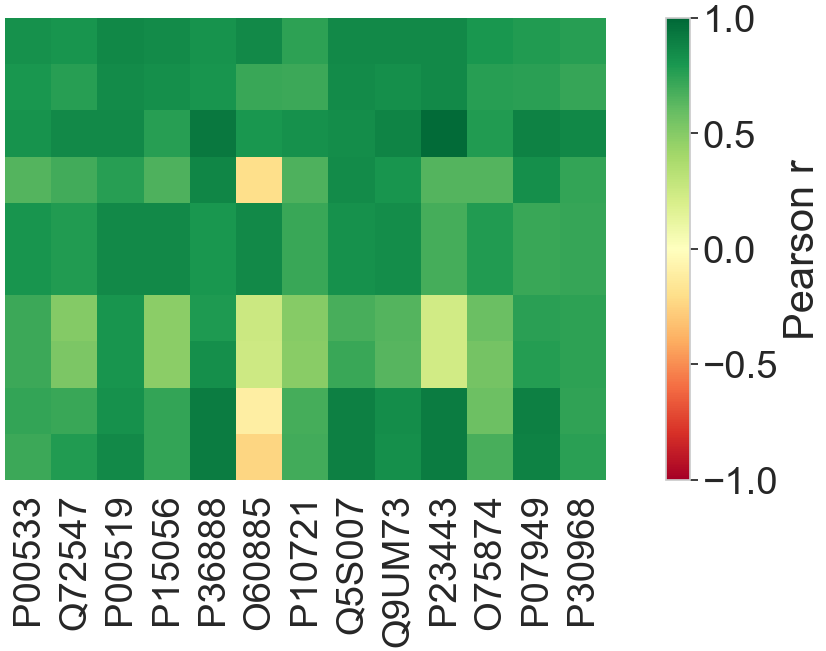

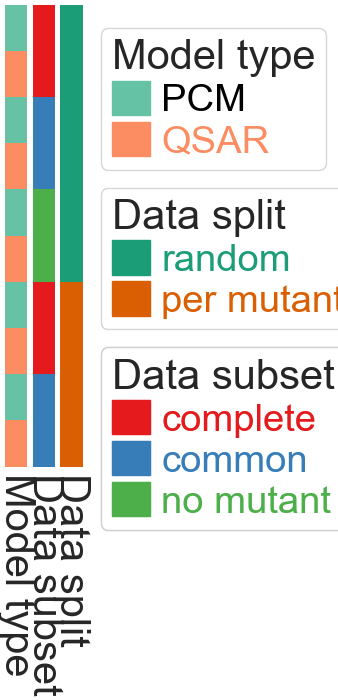

In [49]:
most_interesting_data_heatmap = most_interesting_data_heatmap.reset_index(drop=True)
tick_mapping_most_interesting_data['mutant_fraction'] = tick_mapping_most_interesting_data.num_datapoints_mutants / tick_mapping_most_interesting_data.num_datapoints_total * 100
tick_mapping_most_interesting_data['total_fraction'] = 100 - tick_mapping_most_interesting_data.mutant_fraction

fig, ax = plt.subplots(figsize=(12, 3))
tick_mapping_most_interesting_data['num_datapoints_total'].plot(kind='bar', ax=ax, position=2, color='white', edgecolor='black', label='Number of datapoints', log=True, width=0.2)
tick_mapping_most_interesting_data['num_datapoints_WT'].plot(kind='bar', ax=ax, position=1, color='lightgray', edgecolor='black', label='Number of WT datapoints', log=True, width=0.2)
tick_mapping_most_interesting_data['num_datapoints_mutants'].plot(kind='bar',ax=ax, position=0,  color='#808080', edgecolor='black', label='Number of mutant datapoints', log=True, width=0.2)
ax.set_xticks([])
ax.set_ylim((10, 20_000))
ax.set_xlim((-0.5, tick_mapping_most_interesting_data.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000, 10000]))
ax.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax.xaxis.grid(False)
plt.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), prop={'size': 20})
ax2 = ax.twinx()
tick_mapping_most_interesting_data['num_datapoints_total'].plot(kind='bar', ax=ax2, alpha=0.0, log=True)
ax2.yaxis.grid(False)
ax.set_xticks([])
ax2.set_ylim((10, 20_000))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', right=True)
ax2.yaxis.set_major_locator(FixedLocator([1, 10, 100, 1000]))
ax2.yaxis.set_minor_locator(LogLocator(numticks=999, subs=(.1, .2, .3, .4, 0.5, 0.6, 0.7, 0.8, 0.9)))
ax2.grid(False, which='minor')
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_interesting_data.elem1.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(x=tick_mapping_most_interesting_data['text'], height=tick_mapping_most_interesting_data['total_fraction'],
       bottom=tick_mapping_most_interesting_data['mutant_fraction'],
       color='lightgray', edgecolor='black', label='WT data fraction')
ax.bar(x=tick_mapping_most_interesting_data['text'], height=tick_mapping_most_interesting_data['mutant_fraction'],
       color='#808080', edgecolor='black', label='Mutant data fraction')
ax.set_xticks([])
ax.set_ylim((0, 100))
ax.set_xlim((-0.5, tick_mapping_most_interesting_data.shape[0]-0.4))
ax.minorticks_on()
ax.tick_params(axis='y', which='both', left=True)
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.grid(False)
ax.grid(True, axis='y', which='minor', color='lightgrey', linewidth=0.2)
ax2 = ax.twinx()
ax2.set_ylim((0, 100))
ax2.minorticks_on()
ax2.tick_params(axis='y', which='both', left=True)
ax2.grid(False, axis='y', which='both')
ax2.yaxis.set_major_locator(MultipleLocator(25))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_interesting_data.elem2.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(most_interesting_data_heatmap.iloc[:, 3:], vmin=-1, vmax=1, cmap=colormaps.get_cmap('RdYlGn')) #LinearSegmentedColormap.from_list("", ["#D43B61", "#FAE3D1","white", "#CDE8D3","#34ADAB"])
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax, label='Pearson r')
_ = ax.set_xticks(np.arange(most_interesting_data_heatmap.iloc[:, 3:].shape[1]), labels=most_interesting_data_heatmap.iloc[:, 3:].columns,
                  rotation=90,rotation_mode="anchor", ha='right', va='center')
_ = ax.get_yaxis().set_ticks([])
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_interesting_data.elem3.svg'))
plt.show()


fig, ax = plt.subplots(figsize=(1, 6))
row_ha = HeatmapAnnotation(**{'Model type': anno_simple(most_interesting_data_heatmap.modeltype, legend=True, cmap='Set2', height=6)},
                           **{'Data subset': anno_simple(most_interesting_data_heatmap.dataset, legend=True, cmap='Set1', height=6)},
                           **{'Data split': anno_simple(most_interesting_data_heatmap.crossval, legend=True, cmap='Dark2', height=6)},
                           label_side='bottom', axis=0, wgap=1.5, orientation='right', plot=True, verbose=False,
                           legend_width=60)
plt.savefig(os.path.join(output_plot_dir, 'Complex_heatmap.most_interesting_data.elem4.svg'))
plt.show()